In [6]:
# STEP 1 — Load data from Postgres, define target/exclusions, make 80/20 split, and fit a baseline model
# (Run this cell/script as-is. It will print baseline metrics and dataset shapes.)

import pandas as pd
from sqlalchemy import create_engine, text
import shap
import matplotlib.pyplot as plt
import numpy as np
import re

pd.options.display.max_columns = 200

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    confusion_matrix,
    roc_curve,
)

from sklearn.model_selection import StratifiedKFold, cross_validate

import os, sys, json, csv, joblib
from pathlib import Path
from datetime import datetime, timezone
import subprocess

In [ ]:
SCRIPT_PATH = Path(".").resolve()
ROOT_DIR    = SCRIPT_PATH.parent.parent                   # modeling/
SAVE_ROOT   = ROOT_DIR / "models" / "pregame_outcome"     # modeling/models/pregame_outcome
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

def _utc_now():
    return datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")

RUN_ID = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
try:
    sha = subprocess.run(["git", "rev-parse", "--short", "HEAD"],
                         capture_output=True, text=True, check=False)
    if sha.returncode == 0 and sha.stdout.strip():
        RUN_ID = f"{RUN_ID}_{sha.stdout.strip()}"
except Exception:
    pass

RUN_DIR = SAVE_ROOT / "runs" / RUN_ID
for sub in ["logs", "metrics", "tables", "predictions", "models", "plots", "extras"]:
    (RUN_DIR / sub).mkdir(parents=True, exist_ok=True)

# ---- Tee stdout/stderr to file while keeping console prints ----
class _Tee:
    def __init__(self, *files): self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj); f.flush()
    def flush(self):
        for f in self.files: f.flush()

_log_f = open(RUN_DIR / "logs" / "run.log", "w", buffering=1)
sys.stdout = _Tee(sys.stdout, _log_f)
sys.stderr = _Tee(sys.stderr, _log_f)

RUN_STARTED_AT = _utc_now()

# ---- helpers ----
def _write_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=str)

_REG_FIELDS = [
    "run_id","started_at","script_path","data_range","target",
    "model_name","is_calibrated","n_train","n_val","n_test",
    "accuracy","roc_auc","pr_auc","logloss","brier","model_path"
]

def _append_registry(row_dict):
    reg_path = SAVE_ROOT / "registry.csv"
    file_exists = reg_path.exists()
    with open(reg_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=_REG_FIELDS)
        if not file_exists:
            w.writeheader()
        w.writerow({k: row_dict.get(k, "") for k in _REG_FIELDS})

In [10]:
# -----------------------------
# Config
# -----------------------------
SEED = 42

DB_NAME = "nfl"
DB_HOST = "localhost"
DB_PORT = 5432
DB_USER = "nfl_user"
DB_PASS = "nfl_pass"
SCHEMA_TABLE = "prod.game_level_modeling_tbl"  # schema-qualified table
SEASON_MIN, SEASON_MAX = 2016, 2025          # inclusive

TARGET = "home_win"

# Never allow market inputs or post-game info
drop_market = ["spread_line", "spread_home"]
drop_for_home_win = [
    "home_score", "away_score",             # postgame
    "margin", "total_points", "spread_covered",  # other targets/leaks
    *drop_market
]
# Non-predictive/temporal ID columns (no time features)
drop_non_predictive = ["game_id", "kickoff"]

In [11]:
# -----------------------------
# Connect & load
# -----------------------------
conn_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(conn_str)

query = text(f"""
    SELECT *
    FROM {SCHEMA_TABLE}
    WHERE season BETWEEN :smin AND :smax
""")

df = pd.read_sql_query(query, engine, params={"smin": SEASON_MIN, "smax": SEASON_MAX})

In [12]:
# -----------------------------
# Target & drops
# -----------------------------
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in table {SCHEMA_TABLE}.")
    
injury_cols = [c for c in df.columns
               if c.startswith("home_inj_") or c.startswith("away_inj_") or c.startswith("diff_inj_")]

# Ensure binary ints {0,1}
#df[TARGET] = df[TARGET].astype(int)

planned_drops = set(drop_for_home_win + drop_non_predictive + injury_cols)
to_drop = [c for c in planned_drops if c in df.columns]

X = df.drop(columns=[TARGET] + to_drop, errors="ignore")
y = df[TARGET].copy()

In [13]:
# -----------------------------
# Feature typing for preprocessing
# - Treat 'season' and 'week' as categorical (one-hot) to capture non-linear/week effects
# - Treat boolean columns as categorical (one-hot)
# -----------------------------
cat_auto = X.select_dtypes(include=["object", "category"]).columns.tolist()
bool_cols = [c for c in X.columns if X[c].dtype == "bool"]
cat_explicit = [c for c in ["season", "week"] if c in X.columns]
cat_features = sorted(set(cat_auto) | set(bool_cols) | set(cat_explicit))

num_features = [c for c in X.columns if c not in cat_features]

In [14]:
# Save a minimal run config (no passwords)
_config = {
    "seed": SEED,
    "db": {
        "name": DB_NAME, "host": DB_HOST, "port": DB_PORT, "user": DB_USER,
        "table": SCHEMA_TABLE, "where": f"season BETWEEN {SEASON_MIN} AND {SEASON_MAX}"
    },
    "target": TARGET,
    "season_min": SEASON_MIN,
    "season_max": SEASON_MAX,
    "drops": {
        "for_target": sorted([c for c in drop_for_home_win if c in df.columns]),
        "non_predictive": sorted([c for c in drop_non_predictive if c in df.columns]),
        "injury_cols": sorted([c for c in injury_cols if c in df.columns]),
    },
    "features": {
        "numeric": num_features,
        "categorical": cat_features
    },
    "script_path": str(SCRIPT_PATH),
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT
}
_write_json(RUN_DIR / "config.json", _config)

In [15]:
# -----------------------------
# Preprocessor (uniform for all models)
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

In [16]:
# -----------------------------
# Time-aware split:
#   - Train/Val: seasons <= 2023 (random 80/20, stratified)
#   - Test: seasons >= 2024 (out-of-time holdout)
# -----------------------------
# Masks
label_mask        = df[TARGET].notna()
trainval_mask     = (df["season"] <= 2023) & label_mask
test2024_mask     = (df["season"] == 2024) & label_mask
action2025_mask   = (df["season"] >= 2025)  # action set; labels may be missing

# Subsets
X_trainval = X.loc[trainval_mask]
y_trainval = y.loc[trainval_mask]

X_test     = X.loc[test2024_mask]
y_test     = y.loc[test2024_mask]

X_action   = X.loc[action2025_mask]  # no y for action predictions

# Train/Val split within 2016–2023
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,
    random_state=SEED,
    stratify=y_trainval
)

print("Shapes:")
print(f"  X_train: {X_train.shape}, X_val: {X_val.shape}, X_test(2024): {X_test.shape}, X_action(2025+): {X_action.shape}")
print(f"  y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

print("\nTarget distribution:")
print(f"  Train: pos={y_train.mean():.3f}, n={y_train.shape[0]}")
print(f"  Val  : pos={y_val.mean():.3f}, n={y_val.shape[0]}")
print(f"  Test : pos={y_test.mean():.3f}, n={y_test.shape[0]}")

In [17]:
# -----------------------------
# Baseline: Dummy (prior) via a unified pipeline
# -----------------------------
baseline = DummyClassifier(strategy="prior", random_state=SEED)

pipe_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", baseline),
])

pipe_baseline.fit(X_train, y_train)

# Validation predictions (2016–2023 holdout)
proba_val = pipe_baseline.predict_proba(X_val)[:, 1]
pred_val = (proba_val >= 0.5).astype(int)

# Test predictions (2024–2025 true holdout) — keeps old var names alive
proba_test = pipe_baseline.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

In [18]:
# -----------------------------
# Metrics
# -----------------------------
acc = accuracy_score(y_test, pred_test)
try:
    roc = roc_auc_score(y_test, proba_test)
except ValueError:
    roc = float("nan")  # guard in case of a degenerate split

prauc = average_precision_score(y_test, proba_test)
ll = log_loss(y_test, proba_test, labels=[0, 1])
brier = brier_score_loss(y_test, proba_test)

print("\nBaseline (DummyClassifier: strategy='prior') metrics on TEST:")
print(f"  Accuracy     : {acc:.4f}")
print(f"  ROC-AUC      : {roc:.4f}")
print(f"  PR-AUC       : {prauc:.4f}")
print(f"  Log Loss     : {ll:.4f}")
print(f"  Brier Score  : {brier:.4f}")

In [19]:
# -----------------------------
# Audit info
# -----------------------------
print("\nColumns dropped for leakage / non-predictive (present in data):")
print(sorted([c for c in to_drop if c in df.columns]))

print("\nFeature counts by type (after drop, before OHE):")
print(f"  Numeric: {len(num_features)}")
print(f"  Categorical (incl. season/week/bool): {len(cat_features)}")

print("\nStep 1 complete. Ready for Step 2: build the LR-EN pipeline + CV?")

In [20]:
# ---------------------------------
# Build LR-EN pipeline (train 2016–2023; eval on 2016–2023 val and 2024 test; make 2025 action preds)
# ---------------------------------
lr_en = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.5,   # tuned via grid
    C=1.0,          # tuned via grid
    max_iter=5000,
    n_jobs=-1,
    random_state=SEED,
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", lr_en),
])

param_grid_lr = {
    "model__C": [0.1, 1.0, 10.0],
    "model__l1_ratio": [0.0, 0.5, 1.0],  # 0=L2, 1=L1
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring="neg_log_loss",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

grid_lr.fit(X_train, y_train)

print("\nLR-EN — Best Params (CV):", grid_lr.best_params_)
print("LR-EN — Best CV LogLoss  :", -grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

# Validation predictions (2016–2023 val)
proba_val_lr = best_lr.predict_proba(X_val)[:, 1]
pred_val_lr  = (proba_val_lr >= 0.5).astype(int)

# Test predictions (2024 only)
proba_test_lr = best_lr.predict_proba(X_test)[:, 1]
pred_test_lr  = (proba_test_lr >= 0.5).astype(int)

# Simple metrics
try:
    roc_val = roc_auc_score(y_val, proba_val_lr)
except ValueError:
    roc_val = float("nan")
try:
    roc_test = roc_auc_score(y_test, proba_test_lr)
except ValueError:
    roc_test = float("nan")

print(f"\nLR-EN — Val  ROC-AUC: {roc_val:.4f}, LogLoss: {log_loss(y_val, proba_val_lr):.4f}")
print(f"LR-EN — Test ROC-AUC: {roc_test:.4f}, LogLoss: {log_loss(y_test, proba_test_lr):.4f}")

# Action predictions (2025, labels may be missing)
if X_action.shape[0] > 0:
    proba_action_lr = best_lr.predict_proba(X_action)[:, 1]
    pred_action_lr  = (proba_action_lr >= 0.5).astype(int)
    print(f"\nLR-EN — Action 2025 predictions made: n={X_action.shape[0]}")

In [21]:
# ---------------------------------
# Evaluate LR-EN on TEST (2024) + Vegas comparison + Action (2025) views
# NOTE: Correct Vegas rule:
#   spread_home < 0 -> AWAY favored -> vegas_pred_home_win = 0
#   spread_home > 0 -> HOME favored -> vegas_pred_home_win = 1
#   spread_home == 0 -> push (ignored)
# ---------------------------------

# Predictions (2024 test)
proba_test = best_lr.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

# Metrics (2024 test)
acc   = accuracy_score(y_test, pred_test)
roc   = roc_auc_score(y_test, proba_test)
prauc = average_precision_score(y_test, proba_test)
ll    = log_loss(y_test, proba_test, labels=[0, 1])
brier = brier_score_loss(y_test, proba_test)
cm    = confusion_matrix(y_test, pred_test)

print("\nLR-EN metrics on 2024 TEST:")
print(f"  Accuracy     : {acc:.4f}")
print(f"  ROC-AUC      : {roc:.4f}")
print(f"  PR-AUC       : {prauc:.4f}")
print(f"  Log Loss     : {ll:.4f}")
print(f"  Brier Score  : {brier:.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(cm)

# --- Vegas baseline on TEST (2024) ---
vegas_pred_test = None
if "spread_home" in df.columns:
    spread_test = df.loc[X_test.index, "spread_home"]
    vegas_pred_test = np.where(spread_test < 0, 0,  # AWAY favored -> home loses
                          np.where(spread_test > 0, 1, np.nan))  # HOME favored -> home wins; 0=push
    valid_v = ~np.isnan(vegas_pred_test)
    if valid_v.any():
        vegas_acc = accuracy_score(y_test[valid_v], vegas_pred_test[valid_v].astype(int))
        vegas_brier = brier_score_loss(y_test[valid_v], vegas_pred_test[valid_v])
        print(f"\nVegas — TEST (2024) Accuracy: {vegas_acc:.4f} | Brier: {vegas_brier:.4f} (ignoring pushes)")
    else:
        print("\nVegas — no usable spreads on TEST (2024).")
else:
    print("\nVegas — 'spread_home' not found in df; skipping.")

# Schedule view for the 2024 TEST set
schedule_cols = [c for c in ["season", "week", "home_team", "away_team", "season_type", "game_type"] if c in df.columns]
extra_cols = ["spread_home"] if "spread_home" in df.columns else []
schedule_test = (
    df.loc[X_test.index, schedule_cols + extra_cols + [TARGET]]
      .assign(
          pred_proba_home_win = np.round(proba_test, 3),
          pred_home_win       = pred_test,
          vegas_pred_home_win = vegas_pred_test
      )
      .sort_values(["season", "week", "home_team", "away_team"])
)

# ---------------------------------
# Action set (2025): week-by-week summary (model vs Vegas) for labeled weeks
#                    + full table for unlabeled weeks
# ---------------------------------
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action = best_lr.predict_proba(X_action)[:, 1]
    pred_action  = (proba_action >= 0.5).astype(int)

    # Vegas picks for action set
    vegas_pred_action = None
    if "spread_home" in df.columns:
        spread_action = df.loc[X_action.index, "spread_home"]
        vegas_pred_action = np.where(spread_action < 0, 0,
                                np.where(spread_action > 0, 1, np.nan))

    schedule_action = (
        df.loc[X_action.index, schedule_cols + (["spread_home"] if "spread_home" in df.columns else [])]
          .assign(
              pred_proba_home_win = np.round(proba_action, 3),
              pred_home_win       = pred_action,
              vegas_pred_home_win = vegas_pred_action
          )
          .sort_values(["season", "week", "home_team", "away_team"])
    )

    # Labeled weeks summary (model vs Vegas)
    has_labels_mask = df.loc[X_action.index, TARGET].notna()
    if has_labels_mask.any():
        labeled_action = schedule_action.loc[has_labels_mask].copy()
        labeled_action["actual_home_win"] = df.loc[labeled_action.index, TARGET].astype(int)
        labeled_action["correct_model"] = (labeled_action["pred_home_win"] == labeled_action["actual_home_win"]).astype(int)

        if "vegas_pred_home_win" in labeled_action.columns:
            valid_v = labeled_action["vegas_pred_home_win"].notna()
            labeled_action["correct_vegas"] = np.where(
                valid_v,
                (labeled_action.loc[valid_v, "vegas_pred_home_win"].astype(int) ==
                 labeled_action.loc[valid_v, "actual_home_win"]).astype(int),
                np.nan
            )
        else:
            labeled_action["correct_vegas"] = np.nan

        weekly_summary = (
            labeled_action.groupby(["season", "week"], as_index=False)
                          .agg(
                              n=("correct_model", "size"),
                              acc_model=("correct_model", "mean"),
                              acc_vegas=("correct_vegas", "mean")
                          )
                          .sort_values(["season", "week"])
        )
        weekly_summary["acc_model"] = weekly_summary["acc_model"].round(3)
        weekly_summary["acc_vegas"] = weekly_summary["acc_vegas"].round(3)

        season_total = pd.DataFrame({
            "season": [int(labeled_action["season"].iloc[0])],
            "week":   ["TOTAL"],
            "n":      [int(labeled_action.shape[0])],
            "acc_model": [round(labeled_action["correct_model"].mean(), 3)],
            "acc_vegas": [round(labeled_action["correct_vegas"].dropna().mean(), 3) if labeled_action["correct_vegas"].notna().any() else np.nan],
        })
        weekly_summary_with_total = pd.concat([weekly_summary, season_total], ignore_index=True)

        print(f"\n2025 Action — labeled weeks summary (LR vs Vegas; last row = season total):")
        print(weekly_summary_with_total.to_string(index=False))
    else:
        print("\n2025 Action — no labeled weeks found.")

    # Unlabeled weeks: print all predictions (include Vegas if available)
    unlabeled_action = schedule_action.loc[~has_labels_mask].copy()
    if unlabeled_action.shape[0] > 0:
        print(f"\n2025 Action — predictions for unlabeled weeks (all rows): {unlabeled_action.shape[0]}")
        print(unlabeled_action.to_string(index=False))
    else:
        print("\n2025 Action — no unlabeled rows to display.")

In [22]:
# Save LR-EN pipeline
_lr_path = RUN_DIR / "models" / "lr_en.joblib"
joblib.dump(best_lr, _lr_path)

# Registry row for LR-EN
_append_registry({
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT,
    "script_path": str(SCRIPT_PATH),
    "data_range": f"{SEASON_MIN}-{SEASON_MAX}",
    "target": TARGET,
    "model_name": "LR_EN",
    "is_calibrated": 0,
    "n_train": X_train.shape[0],
    "n_val":   X_val.shape[0],
    "n_test":  X_test.shape[0],
    "accuracy": acc, "roc_auc": roc, "pr_auc": prauc, "logloss": ll, "brier": brier,
    "model_path": str(_lr_path)
})

# Save encoder categories & schema snapshot once (from LR pipeline)
try:
    _pre = best_lr.named_steps["preprocess"]
    _enc = _pre.named_transformers_["cat"].named_steps["onehot"]
    _cats = {name: _enc.categories_[i].tolist() for i, name in enumerate(cat_features)}
    _write_json(RUN_DIR / "extras" / "ohe_categories.json", _cats)
except Exception as _e:
    print("[Warn] Could not dump OHE categories:", repr(_e))

_schema = {col: str(dtype) for col, dtype in X.dtypes.items()}
_write_json(RUN_DIR / "extras" / "schema_snapshot.json", _schema)

In [23]:
# ---------------------------------
# Coefficient audit (top |beta| after OHE)
# ---------------------------------
try:
    # Get names after preprocessing (works on sklearn >= 1.0)
    feat_names = best_lr.named_steps["preprocess"].get_feature_names_out()
    coefs = best_lr.named_steps["model"].coef_.ravel()

    import numpy as np
    import pandas as pd
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    topk = coef_df.sort_values("abs_coef", ascending=False).head(25)

    print("\nTop 25 LR-EN coefficients by |value|:")
    for _, r in topk.iterrows():
        print(f"{r.feature:50s}  coef={r.coef:+.4f}")
except Exception as e:
    print("\n[Warn] Could not extract feature names/coefficients cleanly:", repr(e))

print("\nStep 2 complete.")

In [24]:
# ---------------------------------
# Build RF pipeline (train 2016–2023; eval on 2016–2023 val and 2024 test; make 2025 action preds)
# ---------------------------------
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1,
)

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])

# 3 sensible guesses per parameter
param_grid_rf = {
    "model__n_estimators": [300, 600, 1000],
    "model__max_depth": [None, 12, 24],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="neg_log_loss",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

grid_rf.fit(X_train, y_train)

print("\nRF — Best Params (CV):", grid_rf.best_params_)
print("RF — Best CV LogLoss  :", -grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

# Validation predictions (2016–2023 val)
proba_val_rf = best_rf.predict_proba(X_val)[:, 1]
pred_val_rf  = (proba_val_rf >= 0.5).astype(int)

# Test predictions (2024 only)
proba_test_rf = best_rf.predict_proba(X_test)[:, 1]
pred_test_rf  = (proba_test_rf >= 0.5).astype(int)

# Quick metrics
print(f"\nRF — Val  ROC-AUC: {roc_auc_score(y_val, proba_val_rf):.4f}, LogLoss: {log_loss(y_val, proba_val_rf):.4f}")
print(f"RF — Test ROC-AUC: {roc_auc_score(y_test, proba_test_rf):.4f}, LogLoss: {log_loss(y_test, proba_test_rf):.4f}")

# Action predictions (2025, labels may be missing)
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action_rf = best_rf.predict_proba(X_action)[:, 1]
    pred_action_rf  = (proba_action_rf >= 0.5).astype(int)
    print(f"\nRF — Action 2025 predictions made: n={X_action.shape[0]}")

In [25]:
# ---------------------------------
# Evaluate tuned RF on TEST (2024) + Action (2025) views
# Add Vegas baseline comparison using df['spread_home']
#   Rule: spread_home < 0 -> Vegas picks HOME win
#         spread_home > 0 -> Vegas picks AWAY win (home loss)
#         spread_home == 0 -> push (ignored in accuracy)
# ---------------------------------

# TEST (2024) predictions
proba_test = best_rf.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

# Metrics (2024)
acc   = accuracy_score(y_test, pred_test)
roc   = roc_auc_score(y_test, proba_test)
prauc = average_precision_score(y_test, proba_test)
ll    = log_loss(y_test, proba_test, labels=[0, 1])
brier = brier_score_loss(y_test, proba_test)
cm    = confusion_matrix(y_test, pred_test)

print("\nRandom Forest (tuned) — TEST (2024) metrics:")
print(f"  Accuracy     : {acc:.4f}")
print(f"  ROC-AUC      : {roc:.4f}")
print(f"  PR-AUC       : {prauc:.4f}")
print(f"  Log Loss     : {ll:.4f}")
print(f"  Brier Score  : {brier:.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(cm)

# --- Vegas baseline on TEST (2024) ---
if "spread_home" in df.columns:
    spread_test = df.loc[X_test.index, "spread_home"]
    vegas_pred_test = np.where(spread_test > 0, 1,
                         np.where(spread_test < 0, 0, np.nan))  # NaN for pushes
    valid = ~np.isnan(vegas_pred_test)
    if valid.any():
        vegas_acc = accuracy_score(y_test[valid], vegas_pred_test[valid].astype(int))
        vegas_brier = brier_score_loss(y_test[valid], vegas_pred_test[valid])
        print(f"\nVegas — TEST (2024) Accuracy: {vegas_acc:.4f} | Brier: {vegas_brier:.4f} (ignoring pushes)")
    else:
        print("\nVegas — no usable spreads on TEST (2024).")
else:
    vegas_pred_test = None
    print("\nVegas — 'spread_home' not found in df; skipping.")

# Schedule view for 2024 TEST set
schedule_cols = [c for c in ["season", "week", "home_team", "away_team", "season_type", "game_type"] if c in df.columns]
extra_cols = ["spread_home"] if "spread_home" in df.columns else []
schedule_test = (
    df.loc[X_test.index, schedule_cols + extra_cols + [TARGET]]
      .assign(
          pred_proba_home_win = proba_test,
          pred_home_win       = pred_test,
          vegas_pred_home_win = vegas_pred_test
      )
      .sort_values(["season", "week", "home_team", "away_team"])
)
schedule_test["pred_proba_home_win"] = schedule_test["pred_proba_home_win"].round(3)

# ---------------------------------
# ACTION set (2025): week-by-week summary for labeled weeks + full table for unlabeled weeks
# ---------------------------------
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action = best_rf.predict_proba(X_action)[:, 1]
    pred_action  = (proba_action >= 0.5).astype(int)

    # Vegas for action set
    if "spread_home" in df.columns:
        spread_action = df.loc[X_action.index, "spread_home"]
        vegas_pred_action = np.where(spread_action > 0, 1,
                               np.where(spread_action < 0, 0, np.nan))
    else:
        spread_action = None
        vegas_pred_action = None

    schedule_action = (
        df.loc[X_action.index, schedule_cols + (["spread_home"] if "spread_home" in df.columns else [])]
          .assign(
              pred_proba_home_win = np.round(proba_action, 3),
              pred_home_win       = pred_action,
              vegas_pred_home_win = vegas_pred_action
          )
          .sort_values(["season", "week", "home_team", "away_team"])
    )

    # Labeled weeks summary
    has_labels_mask = df.loc[X_action.index, TARGET].notna()
    if has_labels_mask.any():
        labeled_action = schedule_action.loc[has_labels_mask].copy()
        labeled_action["actual_home_win"] = df.loc[labeled_action.index, TARGET].astype(int)
        labeled_action["correct_model"] = (labeled_action["pred_home_win"] == labeled_action["actual_home_win"]).astype(int)

        # Vegas accuracy on labeled rows (ignore pushes/NaN)
        if "vegas_pred_home_win" in labeled_action.columns:
            valid_v = labeled_action["vegas_pred_home_win"].notna()
            labeled_action["correct_vegas"] = np.where(
                valid_v,
                (labeled_action.loc[valid_v, "vegas_pred_home_win"].astype(int) ==
                 labeled_action.loc[valid_v, "actual_home_win"]).astype(int),
                np.nan
            )
        else:
            labeled_action["correct_vegas"] = np.nan

        weekly_summary = (
            labeled_action.groupby(["season", "week"], as_index=False)
                          .agg(
                              n=("correct_model", "size"),
                              acc_model=("correct_model", "mean"),
                              acc_vegas=("correct_vegas", "mean")
                          )
                          .sort_values(["season", "week"])
        )
        weekly_summary["acc_model"] = weekly_summary["acc_model"].round(3)
        if "acc_vegas" in weekly_summary:
            weekly_summary["acc_vegas"] = weekly_summary["acc_vegas"].round(3)

        season_total = pd.DataFrame({
            "season": [int(labeled_action["season"].iloc[0])],
            "week":   ["TOTAL"],
            "n":      [int(labeled_action.shape[0])],
            "acc_model": [round(labeled_action["correct_model"].mean(), 3)],
            "acc_vegas": [round(labeled_action["correct_vegas"].dropna().mean(), 3) if labeled_action["correct_vegas"].notna().any() else np.nan],
        })
        weekly_summary_with_total = pd.concat([weekly_summary, season_total], ignore_index=True)

        print(f"\n2025 Action — labeled weeks summary (model vs Vegas; last row = season total):")
        print(weekly_summary_with_total.to_string(index=False))
    else:
        print("\n2025 Action — no labeled weeks found.")

    # Unlabeled weeks: print all predictions (include Vegas pick if available)
    unlabeled_action = schedule_action.loc[~has_labels_mask].copy()
    if unlabeled_action.shape[0] > 0:
        print(f"\n2025 Action — predictions for unlabeled weeks (all rows): {unlabeled_action.shape[0]}")
        print(unlabeled_action.to_string(index=False))
    else:
        print("\n2025 Action — no unlabeled rows to display.")

In [26]:
_rf_path = RUN_DIR / "models" / "rf.joblib"
joblib.dump(best_rf, _rf_path)

_append_registry({
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT,
    "script_path": str(SCRIPT_PATH),
    "data_range": f"{SEASON_MIN}-{SEASON_MAX}",
    "target": TARGET,
    "model_name": "RF",
    "is_calibrated": 0,
    "n_train": X_train.shape[0],
    "n_val":   X_val.shape[0],
    "n_test":  X_test.shape[0],
    "accuracy": acc, "roc_auc": roc, "pr_auc": prauc, "logloss": ll, "brier": brier,
    "model_path": str(_rf_path)
})

In [27]:
# ---------------------------------
# Feature importances from tuned (pre-calibration) RF
# ---------------------------------
try:
    feat_names = best_rf.named_steps["preprocess"].get_feature_names_out()
    importances = best_rf.named_steps["model"].feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(25)

    print("\nTop 25 RF feature importances:")
    for _, r in imp_df.iterrows():
        print(f"{r.feature:60s}  imp={r.importance:.6f}")
except Exception as e:
    print("\n[Warn] Could not extract RF feature importances cleanly:", repr(e))

In [28]:
# ---------------------------------
# Probability Calibration (isotonic, cv=5) using best RF hyperparams
# ---------------------------------
# Rebuild an unfitted RF with best hyperparameters
best_params_flat = {k.split("__", 1)[1]: v for k, v in grid_rf.best_params_.items()}
rf_best_hp = RandomForestClassifier(
    n_estimators=best_params_flat.get("n_estimators", 600),
    max_depth=best_params_flat.get("max_depth", None),
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1,
)

calibrated_rf = CalibratedClassifierCV(
    estimator=rf_best_hp,
    method="isotonic",
    cv=5,
)

pipe_rf_cal = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", calibrated_rf),
])

pipe_rf_cal.fit(X_train, y_train)

proba_test_cal = pipe_rf_cal.predict_proba(X_test)[:, 1]
pred_test_cal = (proba_test_cal >= 0.5).astype(int)

acc_c = accuracy_score(y_test, pred_test_cal)
roc_c = roc_auc_score(y_test, proba_test_cal)
prauc_c = average_precision_score(y_test, proba_test_cal)
ll_c = log_loss(y_test, proba_test_cal, labels=[0, 1])
brier_c = brier_score_loss(y_test, proba_test_cal)
cm_c = confusion_matrix(y_test, pred_test_cal)

print("\nCalibrated RF (isotonic cv=5) — TEST metrics:")
print(f"  Accuracy     : {acc_c:.4f}")
print(f"  ROC-AUC      : {roc_c:.4f}")
print(f"  PR-AUC       : {prauc_c:.4f}")
print(f"  Log Loss     : {ll_c:.4f}")
print(f"  Brier Score  : {brier_c:.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(cm_c)

print("\nStep 3 complete.")

In [31]:
_rf_cal_path = RUN_DIR / "models" / "rf_isotonic.joblib"
joblib.dump(pipe_rf_cal, _rf_cal_path)

_append_registry({
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT,
    "script_path": str(SCRIPT_PATH),
    "data_range": f"{SEASON_MIN}-{SEASON_MAX}",
    "target": TARGET,
    "model_name": "RF",
    "is_calibrated": 1,
    "n_train": X_train.shape[0],
    "n_val":   X_val.shape[0],
    "n_test":  X_test.shape[0],
    "accuracy": acc_c, "roc_auc": roc_c, "pr_auc": prauc_c, "logloss": ll_c, "brier": brier_c,
    "model_path": str(_rf_cal_path)
})

In [29]:
# ---------------------------------
# Build XGB pipeline (train 2016–2023; eval on 2016–2023 val and 2024 test; make 2025 action preds)
# ---------------------------------
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=SEED,
    n_estimators=800,    # tuned via grid
    max_depth=5,        # tuned via grid
    learning_rate=0.1,  # tuned via grid
    n_jobs=-1,
)

pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb),
])

# 3 sensible guesses per parameter
param_grid_xgb = {
    "model__n_estimators": [400, 800, 1200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.03, 0.10, 0.30],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    scoring="neg_log_loss",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

grid_xgb.fit(X_train, y_train)

print("\nXGB — Best Params (CV):", grid_xgb.best_params_)
print("XGB — Best CV LogLoss  :", -grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_

# Validation predictions (2016–2023 val)
proba_val_xgb = best_xgb.predict_proba(X_val)[:, 1]
pred_val_xgb  = (proba_val_xgb >= 0.5).astype(int)

# Test predictions (2024 only)
proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]
pred_test_xgb  = (proba_test_xgb >= 0.5).astype(int)

# Quick metrics
print(f"\nXGB — Val  ROC-AUC: {roc_auc_score(y_val, proba_val_xgb):.4f}, LogLoss: {log_loss(y_val, proba_val_xgb):.4f}")
print(f"XGB — Test ROC-AUC: {roc_auc_score(y_test, proba_test_xgb):.4f}, LogLoss: {log_loss(y_test, proba_test_xgb):.4f}")

# Action predictions (2025, labels may be missing)
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action_xgb = best_xgb.predict_proba(X_action)[:, 1]
    pred_action_xgb  = (proba_action_xgb >= 0.5).astype(int)
    print(f"\nXGB — Action 2025 predictions made: n={X_action.shape[0]}")

In [30]:
# ---------------------------------
# Evaluate XGB on TEST (2024) + Vegas comparison + Action (2025)
# NOTE: Vegas rule (corrected):
#   spread_home < 0 -> AWAY favored -> vegas_pred_home_win = 0
#   spread_home > 0 -> HOME favored -> vegas_pred_home_win = 1
#   spread_home == 0 -> push (ignored)
# ---------------------------------

# TEST (2024)
proba_test = best_xgb.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

acc   = accuracy_score(y_test, pred_test)
roc   = roc_auc_score(y_test, proba_test)
prauc = average_precision_score(y_test, proba_test)
ll    = log_loss(y_test, proba_test, labels=[0, 1])
brier = brier_score_loss(y_test, proba_test)
cm    = confusion_matrix(y_test, pred_test)

print("\nXGBoost (tuned) — TEST (2024) metrics:")
print(f"  Accuracy     : {acc:.4f}")
print(f"  ROC-AUC      : {roc:.4f}")
print(f"  PR-AUC       : {prauc:.4f}")
print(f"  Log Loss     : {ll:.4f}")
print(f"  Brier Score  : {brier:.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(cm)

# Vegas baseline on TEST (2024)
vegas_pred_test = None
if "spread_home" in df.columns:
    spread_test = df.loc[X_test.index, "spread_home"]
    vegas_pred_test = np.where(spread_test < 0, 0, np.where(spread_test > 0, 1, np.nan))
    valid_v = ~np.isnan(vegas_pred_test)
    if valid_v.any():
        vegas_acc = accuracy_score(y_test[valid_v], vegas_pred_test[valid_v].astype(int))
        vegas_brier = brier_score_loss(y_test[valid_v], vegas_pred_test[valid_v])
        print(f"\nVegas — TEST (2024) Accuracy: {vegas_acc:.4f} | Brier: {vegas_brier:.4f} (ignoring pushes)")
    else:
        print("\nVegas — no usable spreads on TEST (2024).")
else:
    print("\nVegas — 'spread_home' not found in df; skipping.")

# Schedule view for 2024 TEST set
schedule_cols = [c for c in ["season", "week", "home_team", "away_team", "season_type", "game_type"] if c in df.columns]
extra_cols = ["spread_home"] if "spread_home" in df.columns else []
schedule_test = (
    df.loc[X_test.index, schedule_cols + extra_cols + [TARGET]]
      .assign(
          pred_proba_home_win = np.round(proba_test, 3),
          pred_home_win       = pred_test,
          vegas_pred_home_win = vegas_pred_test
      )
      .sort_values(["season", "week", "home_team", "away_team"])
)

# ---------------------------------
# ACTION (2025): labeled weekly summary (model vs Vegas) + unlabeled full table
# ---------------------------------
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action = best_xgb.predict_proba(X_action)[:, 1]
    pred_action  = (proba_action >= 0.5).astype(int)

    vegas_pred_action = None
    if "spread_home" in df.columns:
        spread_action = df.loc[X_action.index, "spread_home"]
        vegas_pred_action = np.where(spread_action < 0, 0, np.where(spread_action > 0, 1, np.nan))

    schedule_action = (
        df.loc[X_action.index, schedule_cols + (["spread_home"] if "spread_home" in df.columns else [])]
          .assign(
              pred_proba_home_win = np.round(proba_action, 3),
              pred_home_win       = pred_action,
              vegas_pred_home_win = vegas_pred_action
          )
          .sort_values(["season", "week", "home_team", "away_team"])
    )

    has_labels_mask = df.loc[X_action.index, TARGET].notna()

    # Labeled weeks: weekly accuracy + season total (model vs Vegas)
    if has_labels_mask.any():
        labeled_action = schedule_action.loc[has_labels_mask].copy()
        labeled_action["actual_home_win"] = df.loc[labeled_action.index, TARGET].astype(int)
        labeled_action["correct_model"] = (labeled_action["pred_home_win"] == labeled_action["actual_home_win"]).astype(int)

        if "vegas_pred_home_win" in labeled_action.columns:
            valid_v = labeled_action["vegas_pred_home_win"].notna()
            labeled_action["correct_vegas"] = np.where(
                valid_v,
                (labeled_action.loc[valid_v, "vegas_pred_home_win"].astype(int) ==
                 labeled_action.loc[valid_v, "actual_home_win"]).astype(int),
                np.nan
            )
        else:
            labeled_action["correct_vegas"] = np.nan

        weekly_summary = (
            labeled_action.groupby(["season", "week"], as_index=False)
                          .agg(
                              n=("correct_model", "size"),
                              acc_model=("correct_model", "mean"),
                              acc_vegas=("correct_vegas", "mean")
                          )
                          .sort_values(["season", "week"])
        )
        weekly_summary["acc_model"] = weekly_summary["acc_model"].round(3)
        weekly_summary["acc_vegas"] = weekly_summary["acc_vegas"].round(3)

        season_total = pd.DataFrame({
            "season": [int(labeled_action["season"].iloc[0])],
            "week":   ["TOTAL"],
            "n":      [int(labeled_action.shape[0])],
            "acc_model": [round(labeled_action["correct_model"].mean(), 3)],
            "acc_vegas": [round(labeled_action["correct_vegas"].dropna().mean(), 3) if labeled_action["correct_vegas"].notna().any() else np.nan],
        })
        weekly_summary_with_total = pd.concat([weekly_summary, season_total], ignore_index=True)

        print(f"\n2025 Action — labeled weeks summary (XGB vs Vegas; last row = season total):")
        print(weekly_summary_with_total.to_string(index=False))
    else:
        print("\n2025 Action — no labeled weeks found.")

    # Unlabeled weeks: full prediction table (include Vegas pick if available)
    unlabeled_action = schedule_action.loc[~has_labels_mask].copy()
    if unlabeled_action.shape[0] > 0:
        print(f"\n2025 Action — predictions for unlabeled weeks (all rows): {unlabeled_action.shape[0]}")
        print(unlabeled_action.to_string(index=False))
    else:
        print("\n2025 Action — no unlabeled rows to display.")

In [32]:
_xgb_path = RUN_DIR / "models" / "xgb.joblib"
joblib.dump(best_xgb, _xgb_path)

_append_registry({
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT,
    "script_path": str(SCRIPT_PATH),
    "data_range": f"{SEASON_MIN}-{SEASON_MAX}",
    "target": TARGET,
    "model_name": "XGB",
    "is_calibrated": 0,
    "n_train": X_train.shape[0],
    "n_val":   X_val.shape[0],
    "n_test":  X_test.shape[0],
    "accuracy": acc, "roc_auc": roc, "pr_auc": prauc, "logloss": ll, "brier": brier,
    "model_path": str(_xgb_path)
})

In [33]:
# ---------------------------------
# Feature importances (gain) and names
# ---------------------------------
try:
    feat_names = best_xgb.named_steps["preprocess"].get_feature_names_out()
    booster = best_xgb.named_steps["model"].get_booster()
    # XGBoost's get_score maps features as f0, f1, ... in the order fed to the model
    gain_dict = booster.get_score(importance_type="gain")
    # Map f{idx} to actual names
    mapped = []
    for k, v in gain_dict.items():
        # k like "f123"
        try:
            idx = int(k[1:])
            mapped.append((feat_names[idx], v))
        except Exception:
            mapped.append((k, v))
    imp_df = pd.DataFrame(mapped, columns=["feature", "gain"]).sort_values("gain", ascending=False).head(25)

    print("\nTop 25 XGB features by gain:")
    for _, r in imp_df.iterrows():
        print(f"{r.feature:60s}  gain={r.gain:.6f}")
except Exception as e:
    print("\n[Warn] Could not extract XGB feature importances cleanly:", repr(e))

In [34]:
# ---------------------------------
# Probability Calibration (isotonic, cv=5) using best XGB hyperparams
# ---------------------------------
best_params_flat = {k.split("__", 1)[1]: v for k, v in grid_xgb.best_params_.items()}
xgb_best_hp = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=SEED,
    n_estimators=best_params_flat.get("n_estimators", 800),
    max_depth=best_params_flat.get("max_depth", 5),
    learning_rate=best_params_flat.get("learning_rate", 0.1),
    n_jobs=-1,
)

calibrated_xgb = CalibratedClassifierCV(
    estimator=xgb_best_hp,
    method="isotonic",
    cv=5,
)

pipe_xgb_cal = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", calibrated_xgb),
])

pipe_xgb_cal.fit(X_train, y_train)

proba_test_cal = pipe_xgb_cal.predict_proba(X_test)[:, 1]
pred_test_cal = (proba_test_cal >= 0.5).astype(int)

acc_c = accuracy_score(y_test, pred_test_cal)
roc_c = roc_auc_score(y_test, proba_test_cal)
prauc_c = average_precision_score(y_test, proba_test_cal)
ll_c = log_loss(y_test, proba_test_cal, labels=[0, 1])
brier_c = brier_score_loss(y_test, proba_test_cal)
cm_c = confusion_matrix(y_test, pred_test_cal)

print("\nCalibrated XGB (isotonic cv=5) — TEST metrics:")
print(f"  Accuracy     : {acc_c:.4f}")
print(f"  ROC-AUC      : {roc_c:.4f}")
print(f"  PR-AUC       : {prauc_c:.4f}")
print(f"  Log Loss     : {ll_c:.4f}")
print(f"  Brier Score  : {brier_c:.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(cm_c)

In [35]:
_xgb_cal_path = RUN_DIR / "models" / "xgb_isotonic.joblib"
joblib.dump(pipe_xgb_cal, _xgb_cal_path)

_append_registry({
    "run_id": RUN_ID,
    "started_at": RUN_STARTED_AT,
    "script_path": str(SCRIPT_PATH),
    "data_range": f"{SEASON_MIN}-{SEASON_MAX}",
    "target": TARGET,
    "model_name": "XGB",
    "is_calibrated": 1,
    "n_train": X_train.shape[0],
    "n_val":   X_val.shape[0],
    "n_test":  X_test.shape[0],
    "accuracy": acc_c, "roc_auc": roc_c, "pr_auc": prauc_c, "logloss": ll_c, "brier": brier_c,
    "model_path": str(_xgb_cal_path)
})

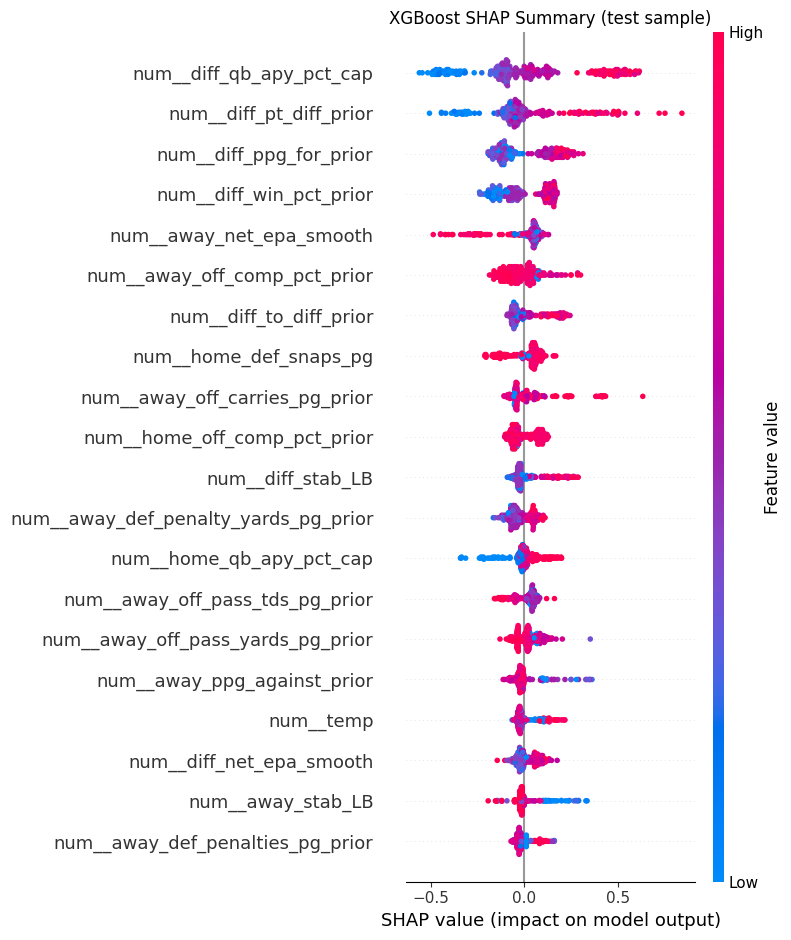

In [43]:
# ---------------------------------
# SHAP summary for tuned (pre-calibration) XGB
# ---------------------------------
try:
    # Transform with the fitted preprocessor from best_xgb
    pre = best_xgb.named_steps["preprocess"]
    X_test_proc = pre.transform(X_test)
    feat_names = pre.get_feature_names_out()

    # Sample for speed if needed
    max_points = 800
    if X_test_proc.shape[0] > max_points:
        rng = np.random.RandomState(SEED)
        idx = rng.choice(X_test_proc.shape[0], size=max_points, replace=False)
        X_shap = X_test_proc[idx]
    else:
        X_shap = X_test_proc

    model = best_xgb.named_steps["model"]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=False)
    plt.title("XGBoost SHAP Summary (test sample)")
    #plt.tight_layout()
    #plt.show()
    
    plt.tight_layout()
    plt.savefig(RUN_DIR / "plots" / "xgb_shap_summary.png", dpi=200)
    plt.show()
except ImportError:
    print("\n[Info] `shap` is not installed. Install with `pip install shap` to render SHAP summaries.")
except Exception as e:
    print("\n[Warn] SHAP computation/plot failed:", repr(e))

print("\nStep 4 complete.")

In [37]:
# ---------------------------------
# Simple voting ensemble (soft vote = average probabilities)
# Uses best_lr, best_rf, best_xgb already fit
# ---------------------------------

# Validation (2016–2023 holdout)
proba_val_vote = (
    best_lr.predict_proba(X_val)[:, 1] +
    best_rf.predict_proba(X_val)[:, 1] +
    best_xgb.predict_proba(X_val)[:, 1]
) / 3.0
pred_val_vote = (proba_val_vote >= 0.5).astype(int)

print("\nVoting Ensemble — VAL metrics:")
print(f"  Accuracy : {accuracy_score(y_val, pred_val_vote):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_val, proba_val_vote):.4f}")
print(f"  Log Loss : {log_loss(y_val, proba_val_vote):.4f}")
print(f"  Brier    : {brier_score_loss(y_val, proba_val_vote):.4f}")

# Test (2024)
proba_test_vote = (
    best_lr.predict_proba(X_test)[:, 1] +
    best_rf.predict_proba(X_test)[:, 1] +
    best_xgb.predict_proba(X_test)[:, 1]
) / 3.0
pred_test_vote = (proba_test_vote >= 0.5).astype(int)

print("\nVoting Ensemble — TEST (2024) metrics:")
print(f"  Accuracy : {accuracy_score(y_test, pred_test_vote):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_test, proba_test_vote):.4f}")
print(f"  Log Loss : {log_loss(y_test, proba_test_vote, labels=[0,1]):.4f}")
print(f"  Brier    : {brier_score_loss(y_test, proba_test_vote):.4f}")
print("  Confusion Matrix [TN FP; FN TP]:")
print(confusion_matrix(y_test, pred_test_vote))

# Action (2025) — predictions only
if 'X_action' in locals() and X_action.shape[0] > 0:
    proba_action_vote = (
        best_lr.predict_proba(X_action)[:, 1] +
        best_rf.predict_proba(X_action)[:, 1] +
        best_xgb.predict_proba(X_action)[:, 1]
    ) / 3.0
    pred_action_vote = (proba_action_vote >= 0.5).astype(int)
    print(f"\nVoting Ensemble — Action 2025 predictions made: n={X_action.shape[0]}")


In [38]:
# ---------------------------------
# Summarize models in single tables (VAL and TEST) + vote column at end
# Now includes Dummy (prior) baseline
# ---------------------------------

def get_metrics(y_true, proba):
    pred = (proba >= 0.5).astype(int)
    # Safe metrics (handle edge cases)
    try:
        roc = roc_auc_score(y_true, proba)
    except ValueError:
        roc = np.nan
    try:
        ll = log_loss(y_true, proba, labels=[0, 1])
    except ValueError:
        ll = np.nan
    return {
        "Accuracy": accuracy_score(y_true, pred),
        "ROC-AUC": roc,
        "PR-AUC": average_precision_score(y_true, proba),
        "LogLoss": ll,
        "Brier": brier_score_loss(y_true, proba),
    }

# ---- VAL (2016–2023 holdout) ----
proba_val_dummy = pipe_baseline.predict_proba(X_val)[:, 1]
proba_val_lr    = best_lr.predict_proba(X_val)[:, 1]
proba_val_rf    = best_rf.predict_proba(X_val)[:, 1]
proba_val_xgb   = best_xgb.predict_proba(X_val)[:, 1]
proba_val_vote  = (proba_val_lr + proba_val_rf + proba_val_xgb) / 3.0

val_summary = pd.DataFrame({
    "DUMMY":     get_metrics(y_val, proba_val_dummy),
    "LR_EN":     get_metrics(y_val, proba_val_lr),
    "RF":        get_metrics(y_val, proba_val_rf),
    "XGB":       get_metrics(y_val, proba_val_xgb),
    "VOTE_SOFT": get_metrics(y_val, proba_val_vote),
})

print("\n=== Validation Summary (2016–2023 holdout) ===")
print(val_summary.round(4).to_string())

# ---- TEST (2024) ----
proba_test_dummy = pipe_baseline.predict_proba(X_test)[:, 1]
proba_test_lr    = best_lr.predict_proba(X_test)[:, 1]
proba_test_rf    = best_rf.predict_proba(X_test)[:, 1]
proba_test_xgb   = best_xgb.predict_proba(X_test)[:, 1]
proba_test_vote  = (proba_test_lr + proba_test_rf + proba_test_xgb) / 3.0

test_summary = pd.DataFrame({
    "DUMMY":     get_metrics(y_test, proba_test_dummy),
    "LR_EN":     get_metrics(y_test, proba_test_lr),
    "RF":        get_metrics(y_test, proba_test_rf),
    "XGB":       get_metrics(y_test, proba_test_xgb),
    "VOTE_SOFT": get_metrics(y_test, proba_test_vote),
})

print("\n=== Test Summary (2024) ===")
print(test_summary.round(4).to_string())

In [39]:
# Save the pretty summary tables
try:
    val_summary.round(6).to_csv(RUN_DIR / "tables" / "validation_summary.csv")
    test_summary.round(6).to_csv(RUN_DIR / "tables" / "test_summary.csv")
    # Also store compact JSON for quick inspection
    _write_json(RUN_DIR / "metrics" / "val.json", val_summary.round(6).to_dict())
    _write_json(RUN_DIR / "metrics" / "test.json", test_summary.round(6).to_dict())
except Exception as _e:
    print("[Warn] Could not save summary tables:", repr(_e))

# Build a single TEST predictions table across models (2024)
try:
    if X_test.shape[0] > 0:
        _sched_cols = [c for c in ["season","week","home_team","away_team","season_type","game_type"] if c in df.columns]
        _extra = ["spread_home"] if "spread_home" in df.columns else []
        _test = df.loc[X_test.index, _sched_cols + _extra + [TARGET]].copy()

        # use the already-computed proba/pred vars
        _test["proba_lr"]  = proba_test_lr
        _test["pred_lr"]   = pred_test_lr
        _test["proba_rf"]  = proba_test_rf
        _test["pred_rf"]   = pred_test_rf
        _test["proba_xgb"] = proba_test_xgb
        _test["pred_xgb"]  = pred_test_xgb
        _test["proba_vote"] = proba_test_vote
        _test["pred_vote"]  = pred_test_vote

        if "spread_home" in df.columns:
            _sh = df.loc[X_test.index, "spread_home"]
            _test["vegas_pred_home_win"] = np.where(_sh < 0, 0, np.where(_sh > 0, 1, np.nan))

        for c in ["proba_lr","proba_rf","proba_xgb","proba_vote"]:
            _test[c] = _test[c].round(3)

        _test.sort_values(["season","week","home_team","away_team"]).to_csv(
            RUN_DIR / "predictions" / "test_2024_predictions.csv", index=False
        )
except Exception as _e:
    print("[Warn] Could not save combined TEST predictions:", repr(_e))

In [40]:
# ---------------------------------
# 2025 Action Summary (no dummy) + Unlabeled Predictions Table
# ---------------------------------

if 'X_action' in locals() and X_action.shape[0] > 0:
    # Probabilities / predictions (no dummy)
    proba_action_lr   = best_lr.predict_proba(X_action)[:, 1]
    proba_action_rf   = best_rf.predict_proba(X_action)[:, 1]
    proba_action_xgb  = best_xgb.predict_proba(X_action)[:, 1]
    proba_action_vote = (proba_action_lr + proba_action_rf + proba_action_xgb) / 3.0

    pred_action_lr    = (proba_action_lr   >= 0.5).astype(int)
    pred_action_rf    = (proba_action_rf   >= 0.5).astype(int)
    pred_action_xgb   = (proba_action_xgb  >= 0.5).astype(int)
    pred_action_vote  = (proba_action_vote >= 0.5).astype(int)

    # Schedule + Vegas columns
    schedule_cols = [c for c in ["season", "week", "home_team", "away_team", "season_type", "game_type"] if c in df.columns]
    extra_cols = ["spread_home"] if "spread_home" in df.columns else []

    # Vegas picks (spread_home < 0 => away favored => home loses (0); >0 => home wins (1); 0 => push/NaN)
    vegas_pred_action = None
    if "spread_home" in df.columns:
        sh = df.loc[X_action.index, "spread_home"]
        vegas_pred_action = np.where(sh < 0, 0, np.where(sh > 0, 1, np.nan))

    # Assemble action predictions table
    action_preds = (
        df.loc[X_action.index, schedule_cols + extra_cols]
          .assign(
              proba_lr   = proba_action_lr,
              pred_lr    = pred_action_lr,
              proba_rf   = proba_action_rf,
              pred_rf    = pred_action_rf,
              proba_xgb  = proba_action_xgb,
              pred_xgb   = pred_action_xgb,
              proba_vote = proba_action_vote,
              pred_vote  = pred_action_vote,
              vegas_pred_home_win = vegas_pred_action
          )
          .sort_values(["season", "week", "home_team", "away_team"])
    )
    
    try:
        if 'action_preds' in locals():
            action_preds.to_csv(RUN_DIR / "predictions" / "action_2025_predictions.csv", index=False)
        if 'action_weekly_summary_2025' in locals():
            action_weekly_summary_2025.to_csv(RUN_DIR / "tables" / "action_2025_weekly_summary.csv", index=False)
        if 'action_unlabeled_2025' in locals():
            action_unlabeled_2025.to_csv(RUN_DIR / "predictions" / "action_2025_unlabeled.csv", index=False)
    except Exception as _e:
        print("[Warn] Could not save 2025 action outputs:", repr(_e))

    # Round probabilities for display
    for c in ["proba_lr","proba_rf","proba_xgb","proba_vote"]:
        action_preds[c] = action_preds[c].round(3)

    # Labeled vs unlabeled masks within 2025
    has_label_mask = df.loc[X_action.index, TARGET].notna()

    # ---- 2025 labeled weeks: week-by-week summary + season total (add Vegas)
    if has_label_mask.any():
        labeled = action_preds.loc[has_label_mask].copy()
        labeled["actual"] = df.loc[labeled.index, TARGET].astype(int)

        labeled["ok_lr"]   = (labeled["pred_lr"]   == labeled["actual"]).astype(int)
        labeled["ok_rf"]   = (labeled["pred_rf"]   == labeled["actual"]).astype(int)
        labeled["ok_xgb"]  = (labeled["pred_xgb"]  == labeled["actual"]).astype(int)
        labeled["ok_vote"] = (labeled["pred_vote"] == labeled["actual"]).astype(int)

        # Vegas correctness (ignore pushes/NaN)
        if "vegas_pred_home_win" in labeled.columns:
            valid_v = labeled["vegas_pred_home_win"].notna()
            labeled["ok_vegas"] = np.where(
                valid_v,
                (labeled.loc[valid_v, "vegas_pred_home_win"].astype(int) ==
                 labeled.loc[valid_v, "actual"]).astype(int),
                np.nan
            )
        else:
            labeled["ok_vegas"] = np.nan

        weekly = (
            labeled.groupby(["season","week"], as_index=False)
                   .agg(
                       n       = ("actual","size"),
                       acc_lr  = ("ok_lr","mean"),
                       acc_rf  = ("ok_rf","mean"),
                       acc_xgb = ("ok_xgb","mean"),
                       acc_vote= ("ok_vote","mean"),
                       acc_vegas = ("ok_vegas","mean")
                   )
                   .sort_values(["season","week"])
        )
        for c in ["acc_lr","acc_rf","acc_xgb","acc_vote","acc_vegas"]:
            weekly[c] = weekly[c].round(3)

        season_val = int(weekly["season"].iloc[0])
        total = pd.DataFrame({
            "season":   [season_val],
            "week":     ["TOTAL"],
            "n":        [int(labeled.shape[0])],
            "acc_lr":   [round(labeled["ok_lr"].mean(),3)],
            "acc_rf":   [round(labeled["ok_rf"].mean(),3)],
            "acc_xgb":  [round(labeled["ok_xgb"].mean(),3)],
            "acc_vote": [round(labeled["ok_vote"].mean(),3)],
            "acc_vegas":[round(labeled["ok_vegas"].dropna().mean(),3) if labeled["ok_vegas"].notna().any() else np.nan],
        })

        action_weekly_summary_2025 = pd.concat([weekly, total], ignore_index=True)
        print("\n=== 2025 Action — Week-by-Week Accuracy (last row = season total; includes Vegas) ===")
        print(action_weekly_summary_2025.to_string(index=False))
    else:
        print("\n2025 Action — no labeled weeks to summarize.")

    # ---- 2025 unlabeled: full prediction table (include Vegas + spread if available)
    unlabeled = action_preds.loc[~has_label_mask].copy()
    if unlabeled.shape[0] > 0:
        cols_show = schedule_cols + extra_cols + [
            "pred_lr","proba_lr",
            "pred_rf","proba_rf",
            "pred_xgb","proba_xgb",
            "pred_vote","proba_vote",
        ]
        if "vegas_pred_home_win" in unlabeled.columns:
            cols_show += ["vegas_pred_home_win"]
        action_unlabeled_2025 = unlabeled[cols_show]
        print(f"\n=== 2025 Action — Unlabeled Games (n={action_unlabeled_2025.shape[0]}) ===")
        print(action_unlabeled_2025.to_string(index=False))
    else:
        print("\n2025 Action — no unlabeled games.")
else:
    print("No 2025 action set (X_action) available.")

In [53]:
from sklearn.inspection import permutation_importance

def _orig_from_processed(name: str, cat_features: list) -> str:
    # Map ColumnTransformer feature names back to original columns
    # Examples:
    #   "num__off_epa"                  -> "off_epa"
    #   "cat__onehot__home_team_SEA"    -> "home_team"
    #   "cat__onehot__season_2024"      -> "season"
    if name.startswith("num__"):
        return name[5:]
    if name.startswith("cat__"):
        # strip "cat__onehot__"
        s = name.split("__", 2)[-1]
        # find longest categorical feature prefix followed by "_"
        best = None
        for f in cat_features:
            pref = f + "_"
            if s.startswith(pref) and (best is None or len(f) > len(best)):
                best = f
        return best if best is not None else s
    return name

def _lr_top10_aggregated(best_lr, cat_features, num_features, k=10):
    pre = best_lr.named_steps["preprocess"]
    feat_names = pre.get_feature_names_out()
    coefs = best_lr.named_steps["model"].coef_.ravel()

    agg = {}
    for fname, coef in zip(feat_names, coefs):
        orig = _orig_from_processed(fname, cat_features)
        val = abs(float(coef))
        # aggregate by MAX abs(coef) to avoid rewarding high-cardinality OHE
        if orig in agg:
            if val > agg[orig]:
                agg[orig] = val
        else:
            agg[orig] = val
    top = sorted(agg.items(), key=lambda x: x[1], reverse=True)[:k]
    rows = [{"model": "LR_EN", "rank": i, "variable": v, "score": s,
             "method": "abs(coef) aggregated (max)"} for i, (v, s) in enumerate(top, start=1)]
    return rows

def _perm_top10(estimator, X_val, y_val, model_label, k=10, repeats=10, seed=SEED):
    r = permutation_importance(
        estimator, X_val, y_val,
        scoring="roc_auc", n_repeats=repeats, random_state=seed, n_jobs=-1
    )
    df_imp = pd.DataFrame({
        "variable": X_val.columns,
        "score": r.importances_mean
    }).sort_values("score", ascending=False).head(k)
    rows = [{"model": model_label, "rank": i, "variable": v, "score": float(s),
             "method": f"permutation ROC-AUC (n_repeats={repeats})"}
            for i, (v, s) in enumerate(zip(df_imp["variable"], df_imp["score"]), start=1)]
    return rows

# Build rows for LR (coef-based), RF (perm), XGB (perm)
top_rows = []
try:
    top_rows += _lr_top10_aggregated(best_lr, cat_features, num_features, k=10)
except Exception as e:
    print("[Warn] LR_EN top-10 computation failed:", repr(e))

try:
    top_rows += _perm_top10(best_rf, X_val, y_val, model_label="RF", k=10, repeats=10, seed=SEED)
except Exception as e:
    print("[Warn] RF permutation-importance failed:", repr(e))

try:
    top_rows += _perm_top10(best_xgb, X_val, y_val, model_label="XGB", k=10, repeats=10, seed=SEED)
except Exception as e:
    print("[Warn] XGB permutation-importance failed:", repr(e))

# Save a single CSV
try:
    top10_df = pd.DataFrame(top_rows, columns=["model","rank","variable","score","method"])
    out_path = RUN_DIR / "tables" / "top10_variables.csv"
    top10_df.to_csv(out_path, index=False)
    print(f"\nSaved top-10 variables per model -> {out_path}")
except Exception as e:
    print("[Warn] Could not save top-10 variables CSV:", repr(e))

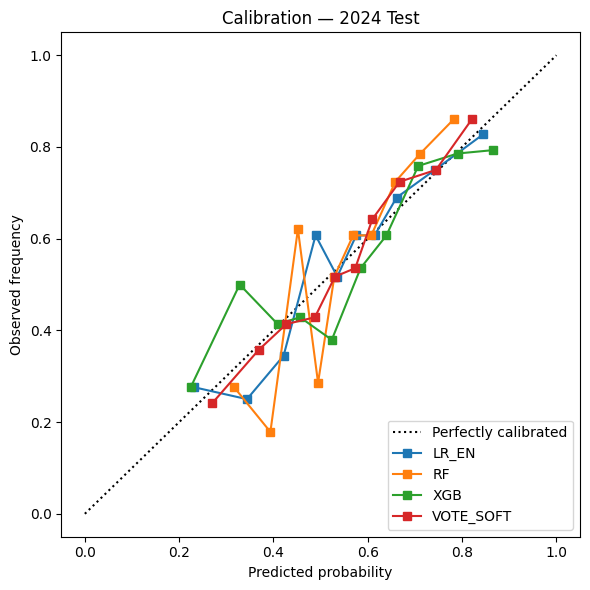

In [42]:
# === Calibration (Reliability) Diagrams — 2024 Test + 2025 Labeled (if any) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss, average_precision_score, accuracy_score

# Helper: simple decile ECE
def ece_decile(y_true, proba):
    df_ = pd.DataFrame({"y": np.asarray(y_true), "p": np.asarray(proba)})
    df_["bin"] = pd.qcut(df_["p"], q=10, duplicates="drop")
    g = df_.groupby("bin", observed=True).agg(emp_rate=("y","mean"), mean_p=("p","mean"), n=("y","size"))
    g["abs_gap"] = (g["emp_rate"] - g["mean_p"]).abs()
    ece = (g["abs_gap"] * (g["n"] / g["n"].sum())).sum()
    return ece, g.reset_index()

# ---------- 2024 TEST ----------
# Ensure test probabilities exist (compute if missing)
if 'proba_test_lr' not in globals():
    proba_test_lr  = best_lr.predict_proba(X_test)[:, 1]
if 'proba_test_rf' not in globals():
    proba_test_rf  = best_rf.predict_proba(X_test)[:, 1]
if 'proba_test_xgb' not in globals():
    proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]

proba_test_vote = (proba_test_lr + proba_test_rf + proba_test_xgb) / 3.0

models_2024 = {
    "LR_EN":     proba_test_lr,
    "RF":        proba_test_rf,
    "XGB":       proba_test_xgb,
    "VOTE_SOFT": proba_test_vote,
}

fig, ax = plt.subplots(figsize=(6, 6))
for name, proba in models_2024.items():
    CalibrationDisplay.from_predictions(y_test, proba, n_bins=10, strategy="quantile", name=name, ax=ax)
ax.set_title("Calibration — 2024 Test")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed frequency")
#plt.tight_layout()
#plt.show()

plt.tight_layout()
plt.savefig(RUN_DIR / "plots" / "calibration_diagram.png", dpi=200)
plt.show()

rows = []
for name, proba in models_2024.items():
    brier = brier_score_loss(y_test, proba)
    ece, _ = ece_decile(y_test, proba)
    rows.append({"Model": name, "Brier": brier, "ECE_decile": ece})
print("\n2024 Calibration summary (lower is better):")
print(pd.DataFrame(rows).round(4).to_string(index=False))

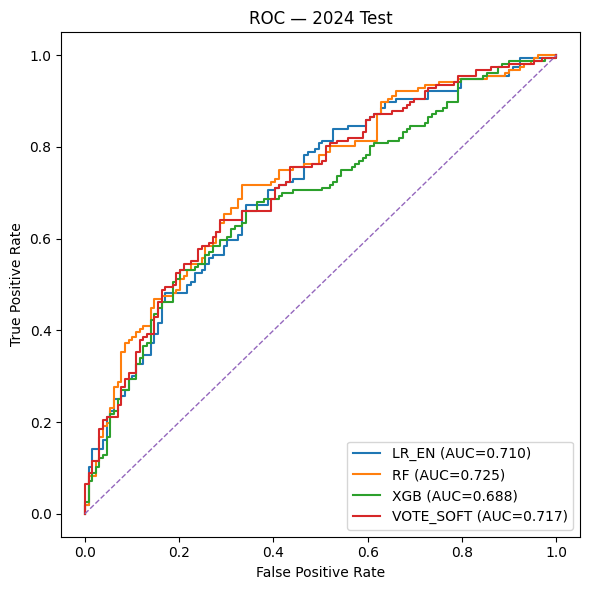

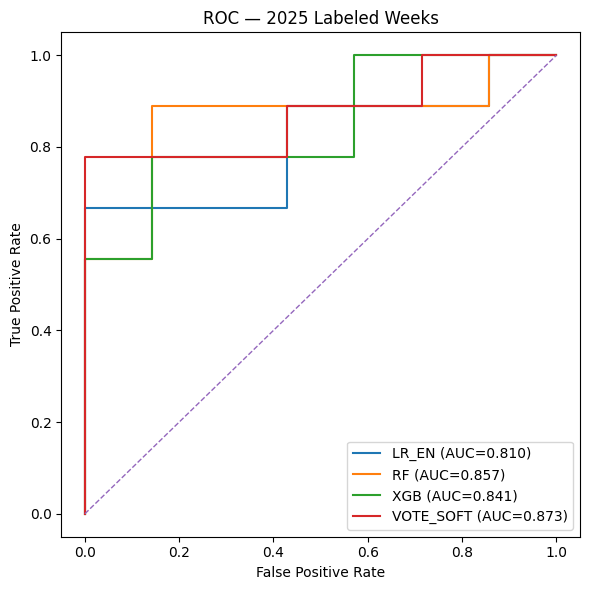

In [44]:
# --- 2024 TEST ---
# Ensure test probabilities exist
if 'proba_test_lr' not in globals():
    proba_test_lr  = best_lr.predict_proba(X_test)[:, 1]
if 'proba_test_rf' not in globals():
    proba_test_rf  = best_rf.predict_proba(X_test)[:, 1]
if 'proba_test_xgb' not in globals():
    proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]
proba_test_vote = (proba_test_lr + proba_test_rf + proba_test_xgb) / 3.0

models_2024 = {
    "LR_EN":     proba_test_lr,
    "RF":        proba_test_rf,
    "XGB":       proba_test_xgb,
    "VOTE_SOFT": proba_test_vote,
}

fig, ax = plt.subplots(figsize=(6, 6))
for name, proba in models_2024.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    try:
        auc = roc_auc_score(y_test, proba)
    except ValueError:
        auc = float("nan")
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax.set_title("ROC — 2024 Test")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(RUN_DIR / "plots" / "roc.png", dpi=200)
plt.show()

# --- 2025 ACTION (labeled only) ---
if 'X_action' in locals() and X_action.shape[0] > 0:
    label_mask_2025 = df.loc[X_action.index, TARGET].notna()
    if label_mask_2025.any():
        X_2025_lab = X_action.loc[label_mask_2025[label_mask_2025].index]
        y_2025_lab = df.loc[X_2025_lab.index, TARGET].astype(int)

        proba_2025_lr   = best_lr.predict_proba(X_2025_lab)[:, 1]
        proba_2025_rf   = best_rf.predict_proba(X_2025_lab)[:, 1]
        proba_2025_xgb  = best_xgb.predict_proba(X_2025_lab)[:, 1]
        proba_2025_vote = (proba_2025_lr + proba_2025_rf + proba_2025_xgb) / 3.0

        models_2025 = {
            "LR_EN":     proba_2025_lr,
            "RF":        proba_2025_rf,
            "XGB":       proba_2025_xgb,
            "VOTE_SOFT": proba_2025_vote,
        }

        fig2, ax2 = plt.subplots(figsize=(6, 6))
        for name, proba in models_2025.items():
            fpr, tpr, _ = roc_curve(y_2025_lab, proba)
            try:
                auc = roc_auc_score(y_2025_lab, proba)
            except ValueError:
                auc = float("nan")
            ax2.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        ax2.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        ax2.set_title("ROC — 2025 Labeled Weeks")
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        ax2.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    else:
        print("No labeled 2025 rows yet — skipping 2025 ROC.")

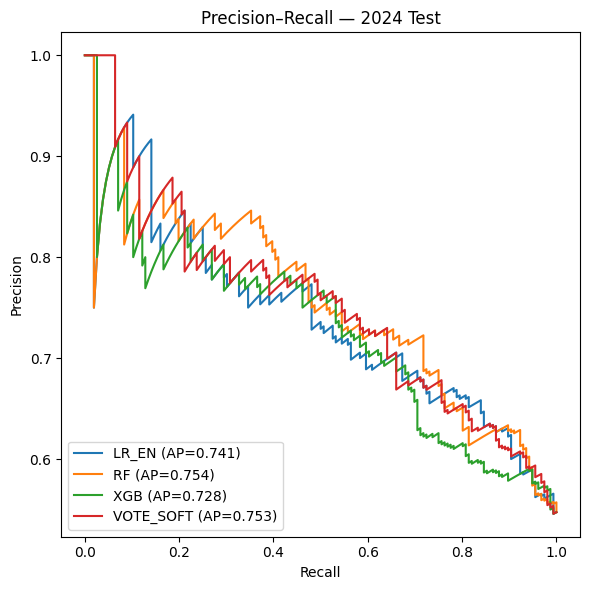

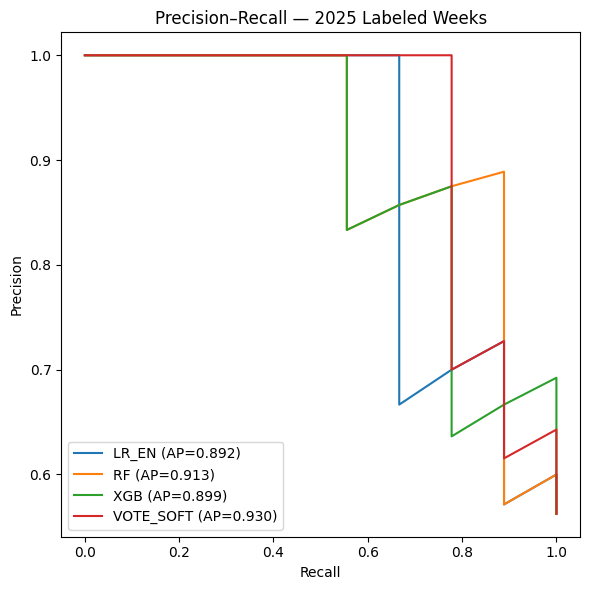

In [45]:
# Ensure test probabilities exist
if 'proba_test_lr' not in globals():
    proba_test_lr  = best_lr.predict_proba(X_test)[:, 1]
if 'proba_test_rf' not in globals():
    proba_test_rf  = best_rf.predict_proba(X_test)[:, 1]
if 'proba_test_xgb' not in globals():
    proba_test_xgb = best_xgb.predict_proba(X_test)[:, 1]
proba_test_vote = (proba_test_lr + proba_test_rf + proba_test_xgb) / 3.0

models_2024 = {
    "LR_EN":     proba_test_lr,
    "RF":        proba_test_rf,
    "XGB":       proba_test_xgb,
    "VOTE_SOFT": proba_test_vote,
}

# 2024
fig, ax = plt.subplots(figsize=(6, 6))
for name, proba in models_2024.items():
    p, r, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax.plot(r, p, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall — 2024 Test")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="lower left")
#plt.tight_layout()
#plt.show()
plt.tight_layout()
plt.savefig(RUN_DIR / "plots" / "precision_recall.png", dpi=200)
plt.show()

# 2025 (labeled only)
if 'X_action' in locals() and X_action.shape[0] > 0:
    mask = df.loc[X_action.index, TARGET].notna()
    if mask.any():
        X_25 = X_action.loc[mask]
        y_25 = df.loc[X_25.index, TARGET].astype(int)
        proba_25_lr   = best_lr.predict_proba(X_25)[:, 1]
        proba_25_rf   = best_rf.predict_proba(X_25)[:, 1]
        proba_25_xgb  = best_xgb.predict_proba(X_25)[:, 1]
        proba_25_vote = (proba_25_lr + proba_25_rf + proba_25_xgb) / 3.0
        models_2025 = {"LR_EN": proba_25_lr, "RF": proba_25_rf, "XGB": proba_25_xgb, "VOTE_SOFT": proba_25_vote}

        fig2, ax2 = plt.subplots(figsize=(6, 6))
        for name, proba in models_2025.items():
            p, r, _ = precision_recall_curve(y_25, proba)
            ap = average_precision_score(y_25, proba)
            ax2.plot(r, p, label=f"{name} (AP={ap:.3f})")
        ax2.set_title("Precision–Recall — 2025 Labeled Weeks")
        ax2.set_xlabel("Recall")
        ax2.set_ylabel("Precision")
        ax2.legend(loc="lower left")
        plt.tight_layout()
        plt.show()

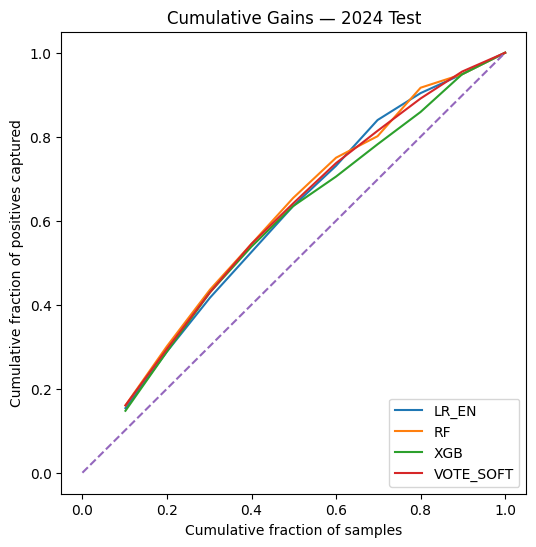

In [46]:
def cumulative_gains(y_true, proba, bins=10):
    df_ = pd.DataFrame({"y": y_true.values, "p": proba}).sort_values("p", ascending=False)
    df_["bucket"] = pd.qcut(df_["p"].rank(method="first"), q=bins, labels=False)
    df_["bucket"] = bins - df_["bucket"]  # 0=top decile
    g = df_.groupby("bucket", as_index=False).agg(n=("y","size"), pos=("y","sum"))
    g["cum_n"]   = g["n"].cumsum()
    g["cum_pos"] = g["pos"].cumsum()
    g["cum_pos_rate"] = g["cum_pos"] / g["pos"].sum()
    g["cum_pct"] = g["cum_n"] / g["n"].sum()
    return g

models = {
    "LR_EN":     proba_test_lr,
    "RF":        proba_test_rf,
    "XGB":       proba_test_xgb,
    "VOTE_SOFT": proba_test_vote,
}

fig, ax = plt.subplots(figsize=(6,6))
for name, proba in models.items():
    g = cumulative_gains(y_test, proba, bins=10)
    ax.plot(g["cum_pct"], g["cum_pos_rate"], label=name)
ax.plot([0,1],[0,1], linestyle="--")  # random baseline
ax.set_title("Cumulative Gains — 2024 Test")
ax.set_xlabel("Cumulative fraction of samples")
ax.set_ylabel("Cumulative fraction of positives captured")
ax.legend(loc="lower right")
#plt.tight_layout()
#plt.show()
plt.savefig(RUN_DIR / "plots" / "cumulative_fraction.png", dpi=200)
plt.show()

print("\nTop-decile positive capture (2024):")
rows = []
for name, proba in models.items():
    g = cumulative_gains(y_test, proba, bins=10)
    top_decile = g.loc[g["cum_pct"]<=0.1, "cum_pos_rate"].max()
    rows.append({"Model": name, "TopDecileCapture": round(float(top_decile), 3)})
print(pd.DataFrame(rows).sort_values("TopDecileCapture", ascending=False).to_string(index=False))

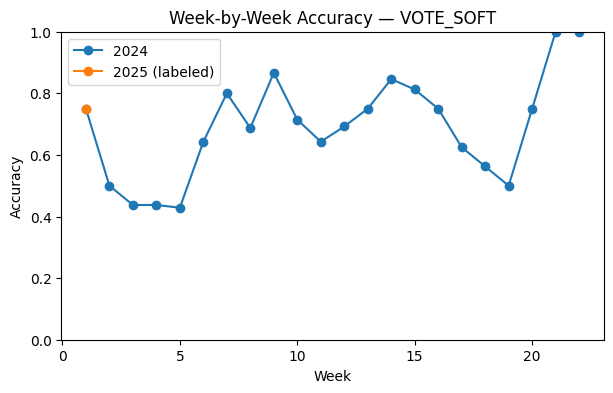

In [49]:
# 2024
pred_2024 = (proba_test_vote >= 0.5).astype(int)
sched_cols = [c for c in ["season","week"] if c in df.columns]
tab_2024 = (df.loc[X_test.index, sched_cols]
              .assign(actual=y_test.values, pred=pred_2024)
              .groupby("week", as_index=False)
              .agg(acc=("actual", lambda a: (a.values==(pred_2024[df.loc[X_test.index].index.get_indexer(a.index)] )).mean())))  # keep simple

# Simpler: recompute correctly
tab_2024 = (df.loc[X_test.index, ["week"]]
              .assign(actual=y_test.values, pred=pred_2024)
              .groupby("week", as_index=False)
              .agg(acc=("actual", lambda x: (x.index.to_series().map(dict(zip(y_test.index, pred_2024)))==x).mean())))
# The above can be finicky; easier version:
tab_2024 = (pd.DataFrame({"week": df.loc[X_test.index, "week"].values,
                          "ok": (pred_2024==y_test.values).astype(int)})
            .groupby("week", as_index=False).agg(acc=("ok","mean")).sort_values("week"))

# 2025 labeled
tab_2025 = None
if 'X_action' in locals() and X_action.shape[0] > 0:
    mask = df.loc[X_action.index, TARGET].notna()
    if mask.any():
        X25_lab = X_action.loc[mask]
        y25_lab = df.loc[X25_lab.index, TARGET].astype(int)
        proba25_vote = (best_lr.predict_proba(X25_lab)[:,1] +
                        best_rf.predict_proba(X25_lab)[:,1] +
                        best_xgb.predict_proba(X25_lab)[:,1]) / 3.0
        pred25_vote = (proba25_vote >= 0.5).astype(int)
        tab_2025 = (pd.DataFrame({
                        "week": df.loc[X25_lab.index, "week"].values,
                        "ok": (pred25_vote==y25_lab.values).astype(int)})
                    .groupby("week", as_index=False).agg(acc=("ok","mean")).sort_values("week"))

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(tab_2024["week"], tab_2024["acc"], marker="o", label="2024")
if tab_2025 is not None and len(tab_2025)>0:
    ax.plot(tab_2025["week"], tab_2025["acc"], marker="o", label="2025 (labeled)")
ax.set_ylim(0,1)
ax.set_title("Week-by-Week Accuracy — VOTE_SOFT")
ax.set_xlabel("Week")
ax.set_ylabel("Accuracy")
ax.legend()
plt.savefig(RUN_DIR / "plots" / "weekly_accuracy.png", dpi=200)
plt.show()

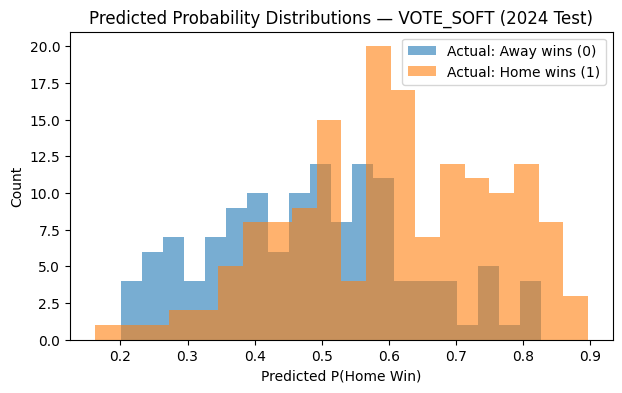

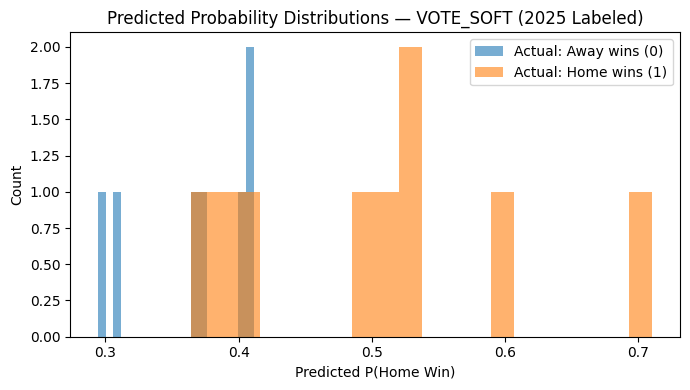

In [51]:
pos = proba_test_vote[y_test.values==1]
neg = proba_test_vote[y_test.values==0]

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(neg, bins=20, alpha=0.6, label="Actual: Away wins (0)")
ax.hist(pos, bins=20, alpha=0.6, label="Actual: Home wins (1)")
ax.set_title("Predicted Probability Distributions — VOTE_SOFT (2024 Test)")
ax.set_xlabel("Predicted P(Home Win)")
ax.set_ylabel("Count")
ax.legend()
plt.savefig(RUN_DIR / "plots" / "outcome_probability_distributions.png", dpi=200)
plt.show()

# (Optional) Repeat for 2025 labeled if present
if 'X_action' in locals() and X_action.shape[0] > 0:
    mask = df.loc[X_action.index, TARGET].notna()
    if mask.any():
        X25_lab = X_action.loc[mask]
        y25_lab = df.loc[X25_lab.index, TARGET].astype(int)
        proba25_vote = (best_lr.predict_proba(X25_lab)[:,1] +
                        best_rf.predict_proba(X25_lab)[:,1] +
                        best_xgb.predict_proba(X25_lab)[:,1]) / 3.0
        pos25 = proba25_vote[y25_lab.values==1]
        neg25 = proba25_vote[y25_lab.values==0]
        fig2, ax2 = plt.subplots(figsize=(7,4))
        ax2.hist(neg25, bins=20, alpha=0.6, label="Actual: Away wins (0)")
        ax2.hist(pos25, bins=20, alpha=0.6, label="Actual: Home wins (1)")
        ax2.set_title("Predicted Probability Distributions — VOTE_SOFT (2025 Labeled)")
        ax2.set_xlabel("Predicted P(Home Win)")
        ax2.set_ylabel("Count")
        ax2.legend()
        plt.tight_layout()
        plt.show()

In [52]:
try:
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
finally:
    try:
        _log_f.close()
    except Exception:
        pass

In [ ]:
# -----------------------------
# Helpers
# -----------------------------
def evaluate_test(name, estimator, X_test, y_test):
    """Return test metrics dict + (proba, pred)."""
    proba = estimator.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        "model": name,
        "test_accuracy": float(accuracy_score(y_test, pred)),
        "test_roc_auc": float(roc_auc_score(y_test, proba)),
        "test_pr_auc": float(average_precision_score(y_test, proba)),
        "test_log_loss": float(log_loss(y_test, proba, labels=[0, 1])),
        "test_brier": float(brier_score_loss(y_test, proba)),
    }
    return metrics, proba, pred

def evaluate_cv(name, estimator, X_train, y_train, seed):
    """Return dict of CV (mean, std) metrics for a fitted estimator (pipeline)."""
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scoring = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision",
        "log_loss": "neg_log_loss",
        "brier": "neg_brier_score",
    }
    cvres = cross_validate(estimator, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, return_estimator=False)

    def mean_std(key, negate=False):
        vals = cvres[f"test_{key}"]
        vals = -vals if negate else vals
        return float(np.mean(vals)), float(np.std(vals))

    acc_m, acc_s = mean_std("accuracy")
    auc_m, auc_s = mean_std("roc_auc")
    pr_m, pr_s  = mean_std("pr_auc")
    ll_m, ll_s  = mean_std("log_loss", negate=True)
    br_m, br_s  = mean_std("brier", negate=True)

    return {
        "model": name,
        "cv_accuracy_mean": acc_m, "cv_accuracy_std": acc_s,
        "cv_roc_auc_mean": auc_m,  "cv_roc_auc_std": auc_s,
        "cv_pr_auc_mean": pr_m,    "cv_pr_auc_std": pr_s,
        "cv_log_loss_mean": ll_m,  "cv_log_loss_std": ll_s,
        "cv_brier_mean": br_m,     "cv_brier_std": br_s,
    }

In [ ]:
# -----------------------------
# Evaluate all four (CV + TEST)
# -----------------------------
models = [
    ("Baseline (Prior)", pipe_baseline, None),   # feature importances: N/A
    ("LR-EN", best_lr, "lr"),
    ("RF (Calibrated)", pipe_rf_cal, "rf"),
    ("XGB (Calibrated)", pipe_xgb_cal, "xgb"),
]

rows = []
probas = {}
preds = {}

for name, est, _ in models:
    # CV on training folds
    row_cv = evaluate_cv(name, est, X_train, y_train, SEED)

    # TEST metrics
    row_test, p_test, yhat_test = evaluate_test(name, est, X_test, y_test)
    row = {**row_cv, **row_test}
    rows.append(row)
    probas[name] = p_test
    preds[name] = yhat_test

metrics_df = pd.DataFrame(rows).set_index("model")
display_cols = [
    # CV
    "cv_accuracy_mean","cv_accuracy_std",
    "cv_roc_auc_mean","cv_roc_auc_std",
    "cv_pr_auc_mean","cv_pr_auc_std",
    "cv_log_loss_mean","cv_log_loss_std",
    "cv_brier_mean","cv_brier_std",
    # TEST
    "test_accuracy","test_roc_auc","test_pr_auc","test_log_loss","test_brier",
]
print("\n=== CV (5-fold on train) and TEST metrics ===")
print(metrics_df[display_cols].round(4))

In [ ]:
# -----------------------------
# Top-10 features per model
# -----------------------------
def get_feature_names(fitted_preprocessor):
    return fitted_preprocessor.get_feature_names_out()

top_rows = []

# Baseline — N/A
df_base = pd.DataFrame({
    "model": ["Baseline (Prior)"] * 10,
    "feature": ["N/A"] * 10,
    "score": [np.nan] * 10
})
top_rows.append(df_base)

# LR-EN: absolute coefficients
try:
    pre = best_lr.named_steps["preprocess"]
    feat_names = get_feature_names(pre)
    coefs = best_lr.named_steps["model"].coef_.ravel()
    df_lr = pd.DataFrame({"feature": feat_names, "score": coefs})
    df_lr["abs"] = df_lr["score"].abs()
    df_lr = df_lr.sort_values("abs", ascending=False).head(10)[["feature","score"]]
    df_lr.insert(0, "model", "LR-EN")
    top_rows.append(df_lr)
except Exception as e:
    print("[Warn] LR-EN feature extraction failed:", repr(e))

# RF: importances from tuned (pre-calibration) RF
try:
    pre = best_rf.named_steps["preprocess"]
    feat_names = get_feature_names(pre)
    imps = best_rf.named_steps["model"].feature_importances_
    df_rf = pd.DataFrame({"feature": feat_names, "score": imps})
    df_rf = df_rf.sort_values("score", ascending=False).head(10)[["feature","score"]]
    df_rf.insert(0, "model", "RF (Calibrated)")
    top_rows.append(df_rf)
except Exception as e:
    print("[Warn] RF importances extraction failed:", repr(e))

# XGB: gain from tuned (pre-calibration) XGB
try:
    pre = best_xgb.named_steps["preprocess"]
    feat_names = get_feature_names(pre)
    booster = best_xgb.named_steps["model"].get_booster()
    gain_dict = booster.get_score(importance_type="gain")
    mapped = []
    for k, v in gain_dict.items():  # "f123" -> index 123
        try:
            idx = int(k[1:])
            mapped.append((feat_names[idx], v))
        except Exception:
            mapped.append((k, v))
    df_xgb = pd.DataFrame(mapped, columns=["feature","score"]).sort_values("score", ascending=False).head(10)
    df_xgb.insert(0, "model", "XGB (Calibrated)")
    top_rows.append(df_xgb)
except Exception as e:
    print("[Warn] XGB gain extraction failed:", repr(e))

top_feats_df = pd.concat(top_rows, ignore_index=True)
print("\n=== Top 10 features per model ===")
print(top_feats_df)

In [ ]:
# -----------------------------
# Confusion matrices (print + heatmaps)
# -----------------------------
for name, _, _ in models:
    cm = confusion_matrix(y_test, preds[name])
    print(f"\n{name} — Confusion Matrix [TN FP; FN TP]:")
    print(cm)

    # Heatmap (matplotlib only)
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} — Confusion Matrix")
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0", "Pred 1"])
    plt.yticks(tick_marks, ["True 0", "True 1"])
    thresh = cm.max() / 2.0 if cm.max() else 0.5
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

In [ ]:
# -----------------------------
# ROC curves (all models)
# -----------------------------
plt.figure()
for name, _, _ in models:
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    auc_val = roc_auc_score(y_test, probas[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\nStep 5 (with CV & TEST metrics) complete.")

In [ ]:
# STEP 6 — Export a full model report (HTML + CSVs + PNGs) and save tuned pipelines
import os, json, math, datetime, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    log_loss, brier_score_loss, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.calibration import calibration_curve
from joblib import dump

# ---------- Config ----------
REPORT_ROOT = "model_reports"
REPORT_NAME = "pregame_home_win"
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
OUTDIR = os.path.join(REPORT_ROOT, f"{REPORT_NAME}_{TIMESTAMP}")
FIGDIR = os.path.join(OUTDIR, "figs")
ARTIFACTSDIR = os.path.join(OUTDIR, "artifacts")
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(ARTIFACTSDIR, exist_ok=True)

MODELS = [
    ("Baseline (Prior)", pipe_baseline, None),        # importances N/A
    ("LR-EN",            best_lr,          "lr"),
    ("RF (Calibrated)",  pipe_rf_cal,      "rf"),     # importances from best_rf
    ("XGB (Calibrated)", pipe_xgb_cal,     "xgb"),    # gain from best_xgb
]

# Try to capture tuning grids if available
best_params = {}
for name, obj in [("LR-EN", "grid_lr"), ("RF", "grid_rf"), ("XGB", "grid_xgb")]:
    try:
        bp = globals()[obj].best_params_
    except Exception:
        bp = None
    best_params[name] = bp

# ---------- Helpers ----------
def compute_test_metrics(estimator, X_test, y_test):
    proba = estimator.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    m = {
        "accuracy": accuracy_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "log_loss": log_loss(y_test, proba, labels=[0, 1]),
        "brier": brier_score_loss(y_test, proba),
    }
    return m, proba, pred

def compute_cv_metrics(estimator, X_train, y_train, seed):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scoring = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision",
        "log_loss": "neg_log_loss",
        "brier": "neg_brier_score",
    }
    res = cross_validate(estimator, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    def mean_std(key, negate=False):
        v = res[f"test_{key}"]
        if negate: v = -v
        return float(np.mean(v)), float(np.std(v))
    acc = mean_std("accuracy")
    auc = mean_std("roc_auc")
    pr  = mean_std("pr_auc")
    ll  = mean_std("log_loss", negate=True)
    br  = mean_std("brier",   negate=True)
    return {
        "cv_accuracy_mean": acc[0], "cv_accuracy_std": acc[1],
        "cv_roc_auc_mean": auc[0],  "cv_roc_auc_std": auc[1],
        "cv_pr_auc_mean": pr[0],    "cv_pr_auc_std": pr[1],
        "cv_log_loss_mean": ll[0],  "cv_log_loss_std": ll[1],
        "cv_brier_mean": br[0],     "cv_brier_std": br[1],
    }

def plot_confusion_matrix(cm, title, path):
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    tick = np.arange(2)
    plt.xticks(tick, ["Pred 0", "Pred 1"])
    plt.yticks(tick, ["True 0", "True 1"])
    thresh = cm.max() / 2.0 if cm.max() else 0.5
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted label"); plt.ylabel("True label")
    plt.tight_layout(); plt.savefig(path, dpi=150); plt.close(fig)

def barh_topk(names, values, title, path, k=10):
    order = np.argsort(values)[::-1]
    order = order[:min(k, len(order))]
    fig = plt.figure()
    plt.barh(range(len(order)), [values[i] for i in order])
    plt.yticks(range(len(order)), [names[i] for i in order])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=150); plt.close(fig)

# ---------- Evaluate models ----------
rows = []
probas = {}
preds = {}
for name, est, _ in MODELS:
    # CV on training data
    cvrow = compute_cv_metrics(est, X_train, y_train, SEED)
    # TEST
    testrow, p, yhat = compute_test_metrics(est, X_test, y_test)
    # Store
    row = {"model": name, **cvrow,
           "test_accuracy": testrow["accuracy"],
           "test_roc_auc": testrow["roc_auc"],
           "test_pr_auc": testrow["pr_auc"],
           "test_log_loss": testrow["log_loss"],
           "test_brier": testrow["brier"]}
    rows.append(row)
    probas[name] = p
    preds[name] = yhat

metrics_df = pd.DataFrame(rows).set_index("model")
metrics_csv = os.path.join(OUTDIR, "metrics_cv_test.csv")
metrics_df.to_csv(metrics_csv, float_format="%.6f")

# ---------- Plots: ROC, PR, Calibration, Confusion ----------
# ROC (overlay)
fig = plt.figure()
for name in metrics_df.index:
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    auc_val = roc_auc_score(y_test, probas[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models")
plt.legend(loc="lower right")
roc_png = os.path.join(FIGDIR, "roc_all.png")
plt.tight_layout(); plt.savefig(roc_png, dpi=150); plt.close(fig)

# PR (overlay)
fig = plt.figure()
for name in metrics_df.index:
    prec, rec, _ = precision_recall_curve(y_test, probas[name])
    ap = average_precision_score(y_test, probas[name])
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves — All Models")
plt.legend(loc="lower left")
pr_png = os.path.join(FIGDIR, "pr_all.png")
plt.tight_layout(); plt.savefig(pr_png, dpi=150); plt.close(fig)

# Calibration curves + ECE
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (y_prob >= lo) & (y_prob < hi) if i < n_bins-1 else (y_prob >= lo) & (y_prob <= hi)
        if np.any(mask):
            p_hat = y_prob[mask].mean()
            y_bar = y_true[mask].mean()
            ece += (mask.mean()) * abs(p_hat - y_bar)
    return float(ece)

fig = plt.figure()
for name in metrics_df.index:
    frac_pos, mean_pred = calibration_curve(y_test, probas[name], n_bins=10, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o", label=f"{name} (ECE≈{expected_calibration_error(y_test, probas[name]):.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration Curves — All Models")
plt.legend(loc="upper left")
cal_png = os.path.join(FIGDIR, "calibration_all.png")
plt.tight_layout(); plt.savefig(cal_png, dpi=150); plt.close(fig)

# Confusion matrices (and save PNGs)
cm_pngs = {}
for name in metrics_df.index:
    cm = confusion_matrix(y_test, preds[name])
    path = os.path.join(FIGDIR, f"cm_{name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}.png")
    plot_confusion_matrix(cm, f"{name} — Confusion Matrix", path)
    cm_pngs[name] = path

# ---------- Top-10 features per model (+ bar charts) ----------
def get_feat_names(fitted_preprocessor):
    return fitted_preprocessor.get_feature_names_out()

tops = []

# Baseline — N/A
tops.append(pd.DataFrame({"model": ["Baseline (Prior)"]*10, "feature": ["N/A"]*10, "score": [np.nan]*10}))

# LR-EN
try:
    pre = best_lr.named_steps["preprocess"]
    names = get_feat_names(pre)
    coefs = best_lr.named_steps["model"].coef_.ravel()
    df_lr = pd.DataFrame({"feature": names, "score": coefs})
    df_lr["abs"] = df_lr["score"].abs()
    df_lr = df_lr.sort_values("abs", ascending=False).head(10)[["feature","score"]]
    df_lr.insert(0, "model", "LR-EN")
    tops.append(df_lr)
    # bar chart
    lr_png = os.path.join(FIGDIR, "top10_lr_en.png")
    barh_topk(df_lr["feature"].values, df_lr["score"].values, "LR-EN — Top 10 Coefficients", lr_png, k=10)
except Exception as e:
    print("[Warn] LR-EN top features failed:", repr(e))

# RF — from best_rf (pre-calibration)
try:
    pre = best_rf.named_steps["preprocess"]
    names = get_feat_names(pre)
    imps = best_rf.named_steps["model"].feature_importances_
    df_rf = pd.DataFrame({"feature": names, "score": imps}).sort_values("score", ascending=False).head(10)
    df_rf.insert(0, "model", "RF (Calibrated)")
    tops.append(df_rf)
    rf_png = os.path.join(FIGDIR, "top10_rf.png")
    barh_topk(df_rf["feature"].values, df_rf["score"].values, "Random Forest — Top 10 Importances", rf_png, k=10)
except Exception as e:
    print("[Warn] RF top features failed:", repr(e))

# XGB — gain from best_xgb (pre-calibration)
try:
    pre = best_xgb.named_steps["preprocess"]
    names = get_feat_names(pre)
    booster = best_xgb.named_steps["model"].get_booster()
    gain = booster.get_score(importance_type="gain")
    mapped = []
    for k, v in gain.items():  # "f123" mapping
        try:
            idx = int(k[1:])
            mapped.append((names[idx], v))
        except Exception:
            mapped.append((k, v))
    df_xgb = pd.DataFrame(mapped, columns=["feature","score"]).sort_values("score", ascending=False).head(10)
    df_xgb.insert(0, "model", "XGB (Calibrated)")
    tops.append(df_xgb)
    xgb_png = os.path.join(FIGDIR, "top10_xgb.png")
    barh_topk(df_xgb["feature"].values, df_xgb["score"].values, "XGBoost — Top 10 (Gain)", xgb_png, k=10)
except Exception as e:
    print("[Warn] XGB top features failed:", repr(e))

top_feats_df = pd.concat(tops, ignore_index=True)
top_feats_csv = os.path.join(OUTDIR, "top10_features.csv")
top_feats_df.to_csv(top_feats_csv, index=False)

# Optional: SHAP summary for XGB
shap_png = None
try:
    import shap
    pre = best_xgb.named_steps["preprocess"]
    Xp = pre.transform(X_test)
    names = pre.get_feature_names_out()
    model = best_xgb.named_steps["model"]
    # sample to speed up
    nmax = 800
    if Xp.shape[0] > nmax:
        rng = np.random.RandomState(SEED)
        idx = rng.choice(Xp.shape[0], size=nmax, replace=False)
        Xs = Xp[idx]
    else:
        Xs = Xp
    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(Xs)
    fig = plt.figure()
    shap.summary_plot(sv, Xs, feature_names=names, show=False)
    plt.title("XGBoost SHAP Summary (test sample)")
    shap_png = os.path.join(FIGDIR, "shap_xgb_summary.png")
    plt.tight_layout(); plt.savefig(shap_png, dpi=150); plt.close(fig)
except Exception as e:
    print("[Info] SHAP not generated:", repr(e))

# ---------- Save fitted pipelines ----------
artifacts = {}
def save_model(obj, fname):
    path = os.path.join(ARTIFACTSDIR, fname)
    dump(obj, path)
    return path

artifacts["baseline_pipeline"] = save_model(pipe_baseline, "baseline_pipeline.joblib")
artifacts["lr_en_pipeline"]    = save_model(best_lr,       "lr_en_pipeline.joblib")
artifacts["rf_cal_pipeline"]   = save_model(pipe_rf_cal,   "rf_calibrated_pipeline.joblib")
artifacts["xgb_cal_pipeline"]  = save_model(pipe_xgb_cal,  "xgb_calibrated_pipeline.joblib")

# ---------- Manifest ----------
manifest = {
    "created_at": TIMESTAMP,
    "seed": SEED,
    "n_train": int(y_train.shape[0]),
    "n_test": int(y_test.shape[0]),
    "class_rate_train": float(y_train.mean()),
    "class_rate_test": float(y_test.mean()),
    "best_params": best_params,
    "artifacts": artifacts,
    "metrics_csv": os.path.abspath(metrics_csv),
    "top_features_csv": os.path.abspath(top_feats_csv),
    "figures": {
        "roc_all": os.path.abspath(roc_png),
        "pr_all": os.path.abspath(pr_png),
        "calibration_all": os.path.abspath(cal_png),
        **{f"cm_{k}": os.path.abspath(v) for k, v in cm_pngs.items()},
        **({"shap_xgb": os.path.abspath(shap_png)} if shap_png else {})
    }
}
with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

# ---------- HTML report ----------
def df_to_html_path(df, path, index=True, floatfmt="%.4f"):
    # round numeric columns for readability
    df_fmt = df.copy()
    for c in df_fmt.columns:
        if pd.api.types.is_numeric_dtype(df_fmt[c]):
            df_fmt[c] = df_fmt[c].map(lambda x: float(x) if not (isinstance(x, float) and (math.isnan(x))) else x))
    html = df_fmt.to_html(index=index)
    with open(path, "w") as f:
        f.write(html)
    return path

metrics_html = os.path.join(OUTDIR, "metrics_cv_test.html")
top_feats_html = os.path.join(OUTDIR, "top10_features.html")
with open(metrics_html, "w") as f:
    f.write(metrics_df.to_html(float_format="%.4f"))
with open(top_feats_html, "w") as f:
    f.write(top_feats_df.to_html(index=False))

html_path = os.path.join(OUTDIR, "report.html")
with open(html_path, "w") as f:
    f.write(f"""<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Model Report — {REPORT_NAME}</title>
  <style>
    body {{ font-family: Arial, sans-serif; margin: 20px; }}
    h1, h2, h3 {{ margin-top: 1.2em; }}
    img {{ max-width: 100%; height: auto; }}
    .grid {{ display: grid; grid-template-columns: 1fr; gap: 14px; }}
    .figrow {{ display: grid; grid-template-columns: 1fr 1fr; gap: 12px; }}
    table {{ border-collapse: collapse; }}
    th, td {{ border: 1px solid #ccc; padding: 6px 8px; }}
  </style>
</head>
<body>
  <h1>Pregame Home Win — Model Report</h1>
  <p><b>Generated:</b> {TIMESTAMP}</p>
  <p><b>Train n:</b> {int(y_train.shape[0])} &nbsp; <b>Test n:</b> {int(y_test.shape[0])} &nbsp; 
     <b>Train pos rate:</b> {y_train.mean():.3f} &nbsp; <b>Test pos rate:</b> {y_test.mean():.3f}</p>

  <h2>CV & Test Metrics</h2>
  {metrics_df.round(4).to_html()}

  <h2>ROC & PR Curves</h2>
  <div class="figrow">
    <div><img src="figs/{os.path.basename(roc_png)}" alt="ROC"></div>
    <div><img src="figs/{os.path.basename(pr_png)}" alt="PR"></div>
  </div>

  <h2>Calibration</h2>
  <img src="figs/{os.path.basename(cal_png)}" alt="Calibration">

  <h2>Confusion Matrices</h2>
  <div class="figrow">
    {"".join(f'<div><h3>{m}</h3><img src="figs/{os.path.basename(p)}" alt="CM {m}"></div>' for m,p in cm_pngs.items())}
  </div>

  <h2>Top 10 Features</h2>
  {top_feats_df.to_html(index=False)}

  <div class="figrow">
    {''.join(f'<div><img src="figs/{fname}" alt="{fname}"></div>' for fname in [
        "top10_lr_en.png", "top10_rf.png", "top10_xgb.png"
    ] if os.path.exists(os.path.join(FIGDIR, fname)))}
  </div>

  {"<h2>SHAP Summary (XGB)</h2><img src=\"figs/" + os.path.basename(shap_png) + "\" alt=\"SHAP XGB\">" if shap_png else ""}

  <h2>Artifacts</h2>
  <ul>
    <li>Baseline: {os.path.basename(artifacts['baseline_pipeline'])}</li>
    <li>LR-EN: {os.path.basename(artifacts['lr_en_pipeline'])}</li>
    <li>RF (Calibrated): {os.path.basename(artifacts['rf_cal_pipeline'])}</li>
    <li>XGB (Calibrated): {os.path.basename(artifacts['xgb_cal_pipeline'])}</li>
  </ul>

  <h2>Best Params</h2>
  <pre>{json.dumps(best_params, indent=2)}</pre>

</body>
</html>""")

print(f"\nReport written to: {html_path}")
print(f"Figures in:        {FIGDIR}")
print(f"Metrics CSV:       {metrics_csv}")
print(f"Top features CSV:  {top_feats_csv}")
print(f"Artifacts in:      {ARTIFACTSDIR}")